In [1]:
import os
import pandas as pd
import numpy as np
import math

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# import plotting packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

from mpl_toolkits.mplot3d import Axes3D # 3d plot
from matplotlib import cm #color map
from matplotlib.ticker import FormatStrFormatter # set decimals in ticks
from matplotlib import rc,re
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator
from LBL_funcs_plotting import make_cmap

# from scope_sw import * # when send the processing part of code to other, update the func.py.
from fun_nearealtime_RTM import *

Sun_Zen=0
local_zen=20
rela_azi=20
COD_guess=15
T_a=299
RH=61
channels=['C01', 'C02', 'C03', 'C04', 'C05', 'C06']
data_dir = './GOES_data/'

/usr/local/anaconda3/envs/RTM/lib/python3.10/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# start

### Sample of results : not run, only for checking


In [111]:
from fun_nearealtime_RTM import nearealtime_RTM
COD_v = np.array([10]) #5,10,15])
Sun_Zen = 60
N_bundles = 10000
for iCOD in COD_v:
    bandmode = 'GOES' # GOES, full
    COD_guess = iCOD
    Rc_rtm,H_c = nearealtime_RTM(Sun_Zen, local_zen, rela_azi, COD_guess, T_a, RH, 
                                 channels, file_dir=data_dir,bandmode=bandmode,N_bundles=N_bundles)
    #Rc_rtm
    #bandmode = 'full'
    # Rc_rtm,H_f = nearealtime_RTM(Sun_Zen, local_zen, rela_azi, COD_guess, T_a, RH, 
    #                              channels, file_dir=data_dir,bandmode=bandmode,N_bundles=N_bundles)
    #Rc_rtm

File uwxyzr_COD=10_th0=60_Ta=299_RH=61.npy not found. Running RTM...
Start MonteCarlo once.
CoeffM,nu= 2509
CPU time: 236.13365507125854
len of uw_rxyz[nuidx=0] 4880
nu_idx [ 578  579  580 ... 1630 1631 1632]
nu_input.shape (2509,)
nu_input[nu_idx] [14290 14293 14296 ... 17446 17449 17452] (1055,)
F_dw_os_SRF 134.24362686188206


# please debug from here

In [46]:
## Since C02 radiance is largest, we test it 
channels = ['C02']

### uw_rxyz  : GOES channel

In [8]:
bandmode = 'channels'  #['fullspectrum','channels']

fdir = "./GOES_data/RTM/" 
filename = '/'+ 'uwxyzr_COD=15_th0=32_Ta=299_RH=61.npy'
file_dir = "./GOES_data/"
#items = [0,1,2,6,5,4,3]
#channels = ['C{:02d}'.format(c) for c in range(1, 6 + 1)]
file_ = fdir + bandmode + filename
results = np.load(file_, allow_pickle=True).item()
uw_rxyz_M=results.get('uw_rxyz_M')

dnu = 3  # spectral resolution 0.1 is enough, 0.01 is too fine, especially for cloudy periods
nu = np.arange(2500, 35000, dnu)
if bandmode == 'full':
    # LBL
    nu_input = nu
else:
    # 6 channels
    channel_6c = ['C{:02d}'.format(c) for c in range(1, 6 + 1)]
    nu_input = goes_calinu(nu, channel_6c, file_dir, dnu=3)

data = np.genfromtxt('data/profiles/SolarTOA.csv', delimiter=',')
ref_lam = data[:, 0]  # in unit of um
ref_E = data[:, 1]  # in unit of W/m2 um
ref_E_nu = -ref_E * ref_lam ** 2 / 1e4

for channel in channels:
    # load calibration data : Spectral Response Func
    channel_number = int(channel[-2:])
    dirpath = file_dir+'abi_calibration/'
    channel_srf = os.path.join(dirpath,
        'GOES-R_ABI_PFM_SRF_CWG_ch{}.txt'.format(channel_number))
    calibration = np.genfromtxt(channel_srf, skip_header=2)
    # calibration_wl = calibration[:, 0]  # wavelength [um]
    calibration_nu = calibration[:, 1]  # cm-1
    # print(calibration_nu.min(),calibration_nu.max())
    calibration_srf = calibration[:, 2] # relative SRF [-]
    nu_channel = goes_calinu(nu, [channel], file_dir, dnu=3)
    # reverse order (so wavenumber is increasing)
    calibration_nu = calibration_nu[::-1]
    calibration_srf = calibration_srf[::-1]
    # Solor TOA and surface albedo
    F_dw_os_channel = -np.interp(-nu_channel, -1e4 / ref_lam, ref_E_nu)  # in wavenumber basis
    # interpolate calibration to match model
    srf = np.interp(nu_channel, calibration_nu, calibration_srf)
    # Normalize SRF if necessary
    F_dw_os_SRF = np.multiply(F_dw_os_channel, srf)

    # Integrate spectral radiance over the channel
    # Channal 2D radiance [W/m2/sr]
    nu_idx = np.nonzero(np.isin(nu_input,nu_channel))[0] # fixed 1 April.
    result = [uw_rxyz_M[i] for i in nu_idx]

    print(len(nu_input[nu_idx]),len(result))

    Rc_rtm,H_c = cal_mono_Intensity(result, Sun_Zen, nu_input[nu_idx], F_dw_os_SRF, local_zen, rela_azi,
                                            is_flux=False, Norm=False, dirc='UW')
    
    print('BON radiance in theta and phi',Rc_rtm)

876 876
BON radiance in theta and phi 13.551518811242842
1055 1055
BON radiance in theta and phi 18.852206420373417
334 334
BON radiance in theta and phi 6.220379414567518
51 51
BON radiance in theta and phi 0.0
130 130
BON radiance in theta and phi 2.010004788170698
63 63
BON radiance in theta and phi 0.3686131668108461


In [54]:
H_theta_6c=np.sum(H_c, axis=1) # H(theta_idx, phi_idx), axis=1, only theta left.

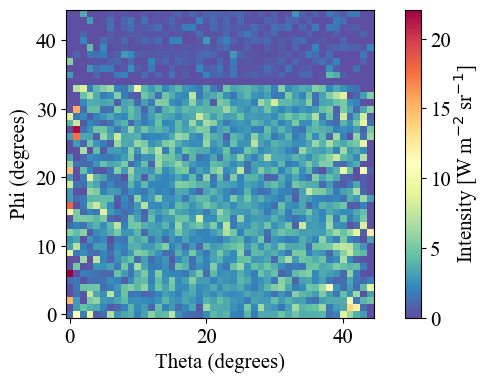

In [10]:
ghi2d_show(H_c, logscale=False)

### uw_rxyz  : full spectrum


In [6]:
channels

['C01', 'C02', 'C03', 'C04', 'C05', 'C06']

In [55]:
bandmode = 'fullspectrum'  #['fullspectrum','channels']

fdir = "./GOES_data/RTM/" 
filename = '/'+ 'uwxyzr_COD=15_th0=32_Ta=299_RH=61.npy'
file_dir = "./GOES_data/"
#items = [0,1,2,6,5,4,3]
#channels = ['C{:02d}'.format(c) for c in range(1, 6 + 1)]
file_ = fdir + bandmode + filename
results = np.load(file_, allow_pickle=True).item()
uw_rxyz_M=results.get('uw_rxyz_M')

dnu = 3  # spectral resolution 0.1 is enough, 0.01 is too fine, especially for cloudy periods
nu = np.arange(2500, 35000, dnu)
if bandmode == 'fullspectrum':
    # LBL
    nu_input = nu
else:
    # 6 channels
    channel_6c = ['C{:02d}'.format(c) for c in range(1, 6 + 1)]
    nu_input = goes_calinu(nu, channel_6c, file_dir, dnu=3)

data = np.genfromtxt('data/profiles/SolarTOA.csv', delimiter=',')
ref_lam = data[:, 0]  # in unit of um
ref_E = data[:, 1]  # in unit of W/m2 um
ref_E_nu = -ref_E * ref_lam ** 2 / 1e4

for channel in channels:
    # load calibration data : Spectral Response Func
    channel_number = int(channel[-2:])
    dirpath = file_dir+'GOES-R_ABI_FM2_SRF_CWG/'
    channel_srf = os.path.join(dirpath,
        'GOES-R_ABI_FM2_SRF_CWG_ch{}.txt'.format(channel_number))
    calibration = np.genfromtxt(channel_srf, skip_header=2)
    # calibration_wl = calibration[:, 0]  # wavelength [um]
    calibration_nu = calibration[:, 1]  # cm-1
    # print(calibration_nu.min(),calibration_nu.max())
    calibration_srf = calibration[:, 2] # relative SRF [-]
    nu_channel = goes_calinu(nu, [channel], file_dir, dnu=3)
    # reverse order (so wavenumber is increasing)
    calibration_nu = calibration_nu[::-1]
    calibration_srf = calibration_srf[::-1]
    # Solor TOA and surface albedo
    F_dw_os_channel = -np.interp(-nu_channel, -1e4 / ref_lam, ref_E_nu)  # in wavenumber basis
    # interpolate calibration to match model
    srf = np.interp(nu_channel, calibration_nu, calibration_srf)
    # Normalize SRF if necessary
    F_dw_os_SRF = np.multiply(F_dw_os_channel, srf)

    # Integrate spectral radiance over the channel
    # Channal 2D radiance [W/m2/sr]
    nu_idx = np.nonzero(np.isin(nu_input,nu_channel))[0] # fixed 1 April.
    result = [uw_rxyz_M[i] for i in nu_idx]

    print(len(nu_input[nu_idx]),len(result))

    Rc_rtm,H_f = cal_mono_Intensity(result, Sun_Zen, nu_input[nu_idx], F_dw_os_SRF, local_zen, rela_azi,
                                            is_flux=False, Norm=False, dirc='UW')
    print('BON radiance in theta and phi',Rc_rtm)

876 876
BON radiance in theta and phi 8.737922016357206
1055 1055
BON radiance in theta and phi 16.15324324165709
334 334
BON radiance in theta and phi 6.8562129260025655
51 51
BON radiance in theta and phi 0.0004166553115938166
130 130
BON radiance in theta and phi 1.3480245006865141
63 63
BON radiance in theta and phi 0.37469904430244777


In [56]:
H_theta=np.sum(H_f, axis=1) # H(theta_idx, phi_idx), axis=1, only theta left.

In [ ]:
# COD=10
print('radiance [t,p]',H_c.max(), H_c.min())
print('radiance [t]',H_theta_6c.max(), H_theta_6c.min())
bins_theta = np.arange(0, 91, 2)
plt.plot(bins_theta[:-1],H_theta - H_theta_6c)
plt.xlabel('theta (degree)')
plt.ylabel('Difference of Radiance (W/m2/sr)')
plt.show()

radiance [t,p] 2.020197971671513 0.0
radiance [t] 12.50575283457189 2.0488849568532572


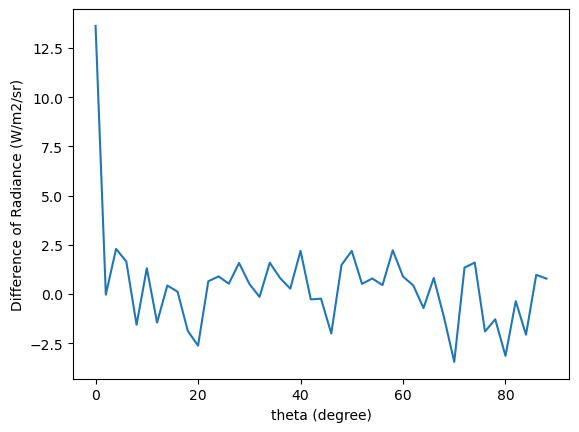

In [34]:
# COD=10
print('radiance [t,p]',H_c.max(), H_c.min())
print('radiance [t]',H_theta_6c.max(), H_theta_6c.min())
bins_theta = np.arange(0, 91, 2)
plt.plot(bins_theta[:-1],H_theta - H_theta_6c)
plt.xlabel('theta (degree)')
plt.ylabel('Difference of Radiance (W/m2/sr)')
plt.show()

radiance [t,p] 1.8335864381908618 0.0
radiance [t] 8.021748833026386 1.7889561557938796


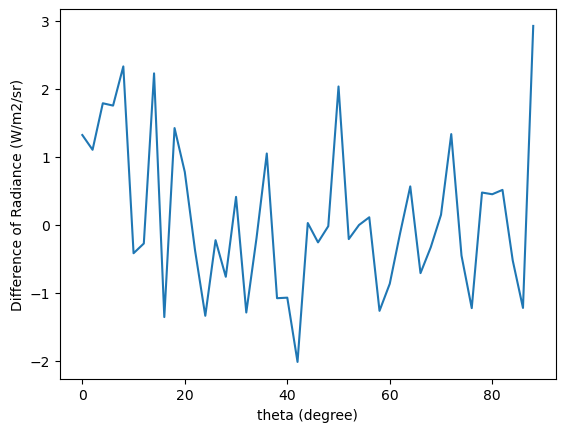

In [ ]:
# COD=0
print('radiance [t,p]',H_c.max(), H_c.min())
print('radiance [t]',H_theta_6c.max(), H_theta_6c.min())
bins_theta = np.arange(0, 91, 2)
plt.plot(bins_theta[:-1],H_theta - H_theta_6c)
plt.xlabel('theta (degree)')
plt.ylabel('Difference of Radiance (W/m2/sr)')
plt.show()

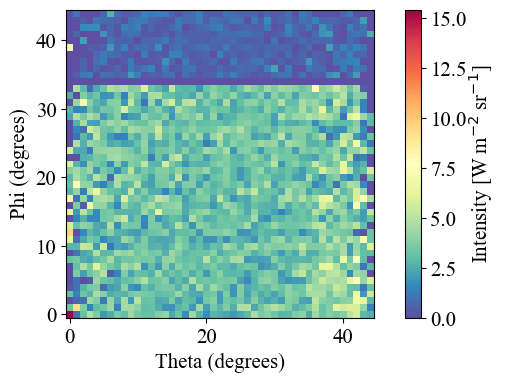

In [13]:
ghi2d_show(H_f, logscale=False)

## difference of Intensity between full and channels

1620


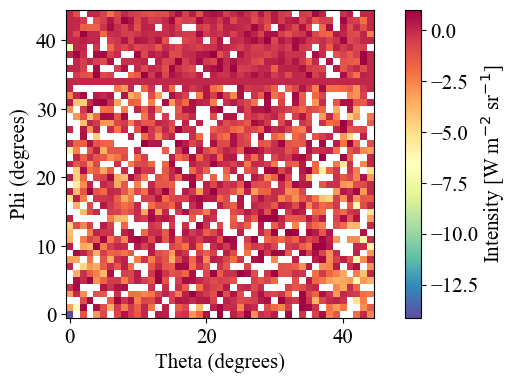

In [14]:
vmax=3
COD=COD_guess
theta0=Sun_Zen
N_bundles=1000
is_Flux=False # Intensity pic

# H = plot_3D_AngDist(H_c, vmax, COD, theta0, N_bundles,is_flux=False,
#                     Norm=False)
diff_H = H_c-H_f
mask = diff_H < 1
print(np.sum(mask))
masked_diff = np.where(mask, diff_H, np.nan)  # Replace non-masked values with NaN
ghi2d_show(masked_diff, logscale=False)

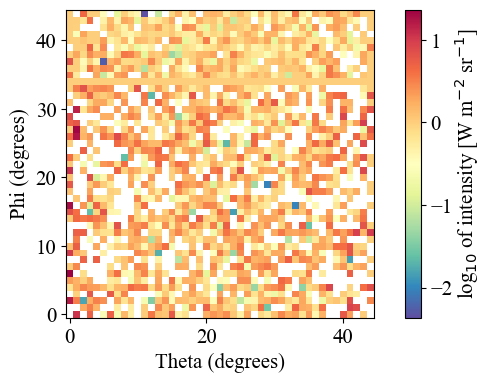

In [15]:
vmax=3
COD=COD_guess
theta0=Sun_Zen
N_bundles=1000
is_Flux=False # Intensity pic

# H = plot_3D_AngDist(H_c, vmax, COD, theta0, N_bundles,is_flux=False,
#                     Norm=False)
ghi2d_show(H_c-H_f, logscale=True)

## F_dw, Flux comparision

full spectral 149.99094613990474
spectral model 149.0263494137988


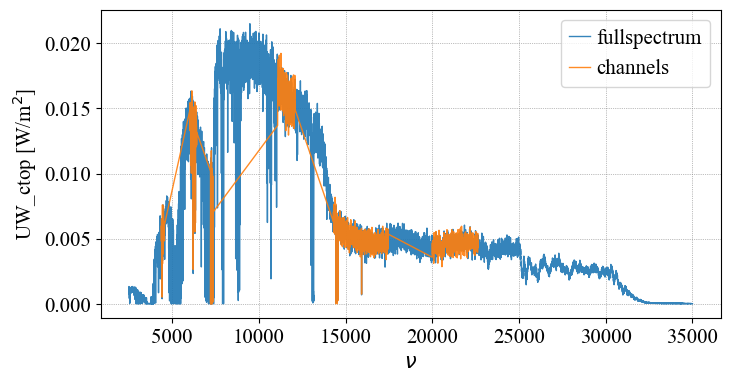

In [16]:
fdir = "./GOES_data/RTM/" 
bandmode = ['fullspectrum','channels']
filename = '/'+ 'Results_case2_AOD=0.1243_COD=0_kap=[10, 11, 12]_th0=32.npy'

#items = [0,1,2,6,5,4,3]
UW_sum=[]
fig = plt.figure(figsize=(8,4))
gs1 = gridspec.GridSpec(1, 1) 
gs1.update(wspace=0.1, hspace=0.15)
ax1 = fig.add_subplot(gs1[0])
nu0 = np.arange(2500, 35000, 3)
channels = ['C{:02d}'.format(c) for c in range(1, 6 + 1)]
for i in range(2):
    if bandmode[i] == 'channels':
        nu = goes_calinu(nu, channels, './GOES_data/', dnu=3)
    else:
        nu = nu0
    file = fdir + bandmode[i] + filename
    results = np.load(file, allow_pickle=True).item()
    Fuw_ctop=results.get('F_uw')
    ax1.plot(nu, Fuw_ctop, label=f'{bandmode[i]}',linewidth=1,alpha=0.9)
    if bandmode[i] == 'channels':
        print('spectral model',np.trapz(Fuw_ctop,nu))
    else:
        nu_input = goes_calinu(nu0, channels, './GOES_data/', dnu=3)
        idx = np.nonzero(np.isin(nu0, nu_input))[0]
        print('full spectral',np.trapz(Fuw_ctop[idx],nu[idx]))
    
ax1.set_xlabel(r"$\nu$")

ax1.set_ylabel(r"UW_ctop [W/m$^2$]")
ax1.grid(color='grey', linestyle=':', linewidth=0.5)

ax1.legend(loc='upper right', ncol=1, columnspacing=0.5,handlelength=1,handletextpad=0.3)

plt.show()
#fig.savefig('COD_UW_ctop_spectrum.png', dpi=300, bbox_inches='tight')

In [17]:
data = np.genfromtxt('data/profiles/SolarTOA.csv', delimiter=',')
ref_lam = data[:, 0]  # in unit of um
ref_E = data[:, 1]  # in unit of W/m2 um
ref_E_nu = -ref_E*ref_lam**2/1e4

## Flux in each channel

C01


NameError: name 'ref_lam' is not defined

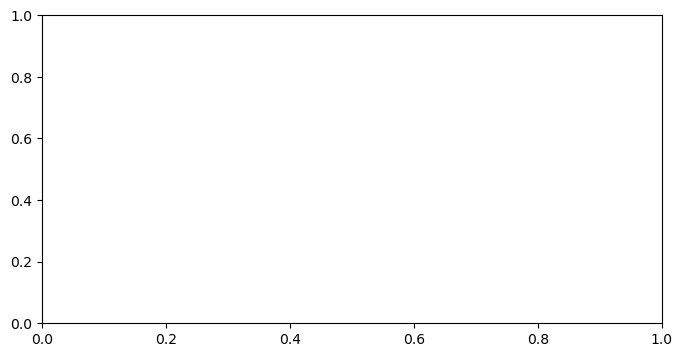

In [7]:
fdir = "./GOES_data/RTM/" 
bandmode = ['channels','fullspectrum',]
filename = '/'+ 'Results_case2_AOD=0.1243_COD=0_kap=[10, 11, 12]_th0=32.npy'

#items = [0,1,2,6,5,4,3]
UW_sum=[]
fig = plt.figure(figsize=(8,4))
gs1 = gridspec.GridSpec(1, 1) 
gs1.update(wspace=0.1, hspace=0.15)
ax1 = fig.add_subplot(gs1[0])
nu0 = np.arange(2500, 35000, 3)
channels = ['C{:02d}'.format(c) for c in range(1, 6 + 1)]
nu_6c = goes_calinu(nu0, channels, './GOES_data/', dnu=3)

for channel in channels:
    for i in range(2):
        file = fdir + bandmode[i] + filename
        results = np.load(file, allow_pickle=True).item()
        Fuw_ctop=results.get('F_uw')
        nu_input = goes_calinu(nu0, [channel], './GOES_data/', dnu=3)
        if bandmode[i] == 'channels':
            idx = np.nonzero(np.isin(nu_6c,nu_input))[0]
            print(channel)
            F_6c = np.trapz(Fuw_ctop[idx],nu_input)
            F_dw_os = -np.interp(-nu_input,-1e4/ref_lam, ref_E_nu) 
            print('F_dw_os',np.trapz(F_dw_os,nu_input))
            print('spectral model',F_6c)
            #ax1.plot(nu, Fuw_ctop, label=f'{bandmode[i]}',linewidth=1,alpha=0.9)
            Fuw_ctop_6c = Fuw_ctop[idx]
        else:
            nu = nu0
            nu_input = goes_calinu(nu0, [channel], './GOES_data/', dnu=3)
            idx = np.nonzero(np.isin(nu0,nu_input))[0]
            F_ = np.trapz(Fuw_ctop[idx],nu_input)
            F_dw_os = -np.interp(-nu_input,-1e4/ref_lam, ref_E_nu) 
            print('F_dw_os',np.trapz(F_dw_os,nu_input))
            print('full spectral',F_)
            print('Relative diff', f"{(F_6c-F_) /F_*100}%")
            ax1.scatter(nu[idx], (Fuw_ctop_6c-Fuw_ctop[idx])/Fuw_ctop[idx]*100, label=f'{channel}',s=5, alpha=0.9)
ax1.set_xlabel(r"$\nu$")
ax1.set_xlim(2500,25000)
ax1.set_ylabel(r"RD full-6c mode")
ax1.grid(color='grey', linestyle=':', linewidth=0.5)

ax1.legend(loc='upper right', ncol=1, columnspacing=0.5,handlelength=1,handletextpad=0.3)

plt.show()
#fig.savefig('COD_UW_ctop_spectrum.png', dpi=300, bbox_inches='tight')

this data above the figure shows 
1. F_dw_os for full spectrum and 6 channels mode is same.

2. The relative difference between the full spectrum and the 6 channels are less than 1%, some the band in channel 4 and 2 has very large relative difference. I guess that is the difference between two mode.

In [ ]:
spectral = 'SW'
N_layer = 54
model='AFGL midlatitude summer'
coeff_M = np.load("data/computed/{}_coeffM_{}layers_{}_dnu={:.2f}cm-1.npy".format(
    spectral, N_layer, model, nu[10]-nu[9]))

print('CoeffM,nu=', nu.shape[0])
coeff_M_6c = np.load("data/computed/GOES_{}_coeffM_{}layers_{}_dnu={:.2f}cm-1.npy".format(
    spectral, N_layer, model, nu[1]-nu[0]))
print('CoeffM,nu=', nu.shape[0])

In [96]:
channel_6c = ['C{:02d}'.format(c) for c in range(1, 6 + 1)]
nu_input = goes_calinu(nu, channel_6c, file_dir, dnu=3)
F_dw_os_srf = []
for channel in channels:
    # load calibration data : Spectral Response Func
    channel_number = int(channel[-2:])
    sensor = 'GOES16'
    if sensor == 'GOES16':
        dirpath = file_dir + 'abi_calibration/'
        channel_srf = os.path.join(dirpath,
                   'GOES-R_ABI_PFM_SRF_CWG_ch{:d}.txt'.format(channel_number))
    else:
        dirpath = file_dir+'GOES-R_ABI_FM2_SRF_CWG/'
        channel_srf = os.path.join(
            dirpath,
             'GOES-R_ABI_FM2_SRF_CWG_ch{}.txt'.format(channel_number)
        )

    calibration = np.genfromtxt(channel_srf, skip_header=2)
    # calibration_wl = calibration[:, 0]  # wavelength [um]
    calibration_nu = calibration[:, 1]  # cm-1
    # print(calibration_nu.min(),calibration_nu.max())
    calibration_srf = calibration[:, 2] # relative SRF [-]
    nu_channel = goes_calinu(nu, [channel], file_dir, dnu=3)
    # reverse order (so wavenumber is increasing)
    calibration_nu = calibration_nu[::-1]
    calibration_srf = calibration_srf[::-1]
    # Solor TOA and surface albedo
    F_dw_os_channel = -np.interp(-nu_channel, -1e4 / ref_lam, ref_E_nu)  # in wavenumber basis
    # interpolate calibration to match model
    srf = np.interp(nu_channel, calibration_nu, calibration_srf)
    # Normalize SRF if necessary
    F_dw_os_SRF = np.multiply(F_dw_os_channel, srf)
    channel_dw =  np.trapz(F_dw_os_SRF,nu_channel)
    F_dw_os_srf.append(channel_dw)
    print('F_dw_os_SRF',channel_dw)

np.save('./GOES_data/'+'F_dw_os_srf.npy', F_dw_os_srf)

F_dw_os_SRF 74.8792286946074
F_dw_os_SRF 134.24362686188206
F_dw_os_SRF 33.70391083269624
F_dw_os_SRF 4.923607608645919
F_dw_os_SRF 11.083403856509042
F_dw_os_SRF 3.5229457149935213


# Theta 

### theta_bin = 2

In [8]:
bins_theta = np.arange(0, 91, 2)
print(bins_theta.shape)
print(bins_theta[:-4])
bins_phi = np.arange(0, 180, 5)
print(bins_phi.shape)

(46,)
[ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46
 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82]
(36,)


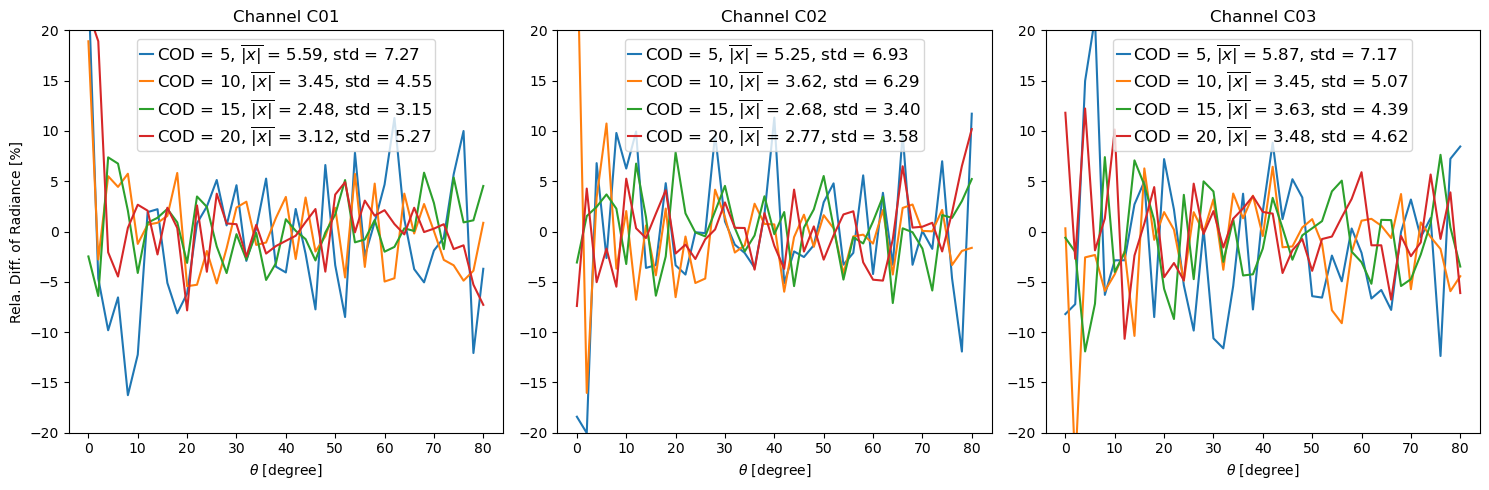

In [4]:
COD_v = np.array([5,10,15,20])
bandmode_v = ['fullspectrum','channels']
bins_theta = np.arange(0, 91, 2)
channels = ['C{:02d}'.format(c) for c in range(1, 3 + 1)]
# Create a figure with 2x3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.ravel()  # Flatten the 2D array of axes for easier indexing
bin_scale = 1
# Loop through each channel
for ch_idx, channel in enumerate(channels):
    for iCOD in COD_v:
        fdir = "./GOES_data/RTM/" 
        filename = '/'+ f'uwxyzr_COD={iCOD}_th0=32_Ta=299_RH=61.npy'
        file_dir = "./GOES_data/"

        for bandmode in bandmode_v:
            file_ = fdir + bandmode + filename
            results = np.load(file_, allow_pickle=True).item()
            uw_rxyz_M=results.get('uw_rxyz_M')
            
            dnu = 3
            nu = np.arange(2500, 35000, dnu)
            if bandmode == 'fullspectrum':
                nu_input = nu
            else:
                channel_6c = ['C{:02d}'.format(c) for c in range(1, 6 + 1)]
                nu_input = goes_calinu(nu, channel_6c, file_dir, dnu=3)

            data = np.genfromtxt('data/profiles/SolarTOA.csv', delimiter=',')
            ref_lam = data[:, 0]
            ref_E = data[:, 1]
            ref_E_nu = -ref_E * ref_lam ** 2 / 1e4
            
            channel_number = int(channel[-2:])
            dirpath = file_dir+'GOES-R_ABI_FM2_SRF_CWG/'
            channel_srf = os.path.join(dirpath,
                'GOES-R_ABI_FM2_SRF_CWG_ch{}.txt'.format(channel_number))
            calibration = np.genfromtxt(channel_srf, skip_header=2)
            calibration_nu = calibration[:, 1]
            calibration_srf = calibration[:, 2]
            nu_channel = goes_calinu(nu, [channel], file_dir, dnu=3)
            
            calibration_nu = calibration_nu[::-1]
            calibration_srf = calibration_srf[::-1]
            
            F_dw_os_channel = -np.interp(-nu_channel, -1e4 / ref_lam, ref_E_nu)
            srf = np.interp(nu_channel, calibration_nu, calibration_srf)
            F_dw_os_SRF = np.multiply(F_dw_os_channel, srf)

            nu_idx = np.nonzero(np.isin(nu_input,nu_channel))[0]
            result = [uw_rxyz_M[i] for i in nu_idx]

            if bandmode != 'channels':
                Rc_rtm,H_f = cal_mono_Intensity(result, Sun_Zen, nu_input[nu_idx], F_dw_os_SRF, local_zen, rela_azi,
                                                    is_flux=False, Norm=False, dirc='UW', bin_scale=bin_scale)
                H_theta=np.sum(H_f, axis=1)
            else:
                Rc_rtm,H_c = cal_mono_Intensity(result, Sun_Zen, nu_input[nu_idx], F_dw_os_SRF, local_zen, rela_azi,
                                                    is_flux=False, Norm=False, dirc='UW', bin_scale=bin_scale)
                H_theta_6c=np.sum(H_c, axis=1)
                
                # Plot in the corresponding subplot
                rela_d = (H_theta_6c-H_theta)/H_theta*100
                mean_val = np.mean(np.abs(rela_d[:-4]))
                std_val = np.std(rela_d[:-4])
                
                label_str = f'COD = {iCOD}, $\\overline{{|x|}}$ = {mean_val:.2f}, std = {std_val:.2f}'
                axs[ch_idx].plot(bins_theta[:-5], rela_d[:-4], label=label_str)
    
    # Set labels and title for each subplot
    # Set labels and title for each subplot
    if ch_idx == 0:
        axs[ch_idx].set_ylabel('Rela. Diff. of Radiance [%]')
    axs[ch_idx].set_xlabel(r'$\theta$ [degree]')
    #axs[ch_idx].set_ylabel('Rela. Diff. of Radiance between full and 6c') #(W/m2/sr)
    axs[ch_idx].set_title(f'Channel {channel}')
    axs[ch_idx].legend(loc='upper center', prop={'size': 12}, handlelength=0.8,
                       handletextpad=0.2, borderpad=0.2, labelspacing=0.2)
    axs[ch_idx].set_ylim(-20, 20)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('Intg_bin_theta=5_COD=[5,10,15,20]_uncertainty_macOS.png', dpi=300, bbox_inches='tight')
plt.show()

### theta_bin = 4

In [46]:
bins_theta = np.arange(0, 91, 2*2)
print(bins_theta.shape)
print(bins_theta[:-4])
bins_phi = np.arange(0, 180, 5*2)
print(bins_phi.shape)

(23,)
[ 0  4  8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72]
(18,)


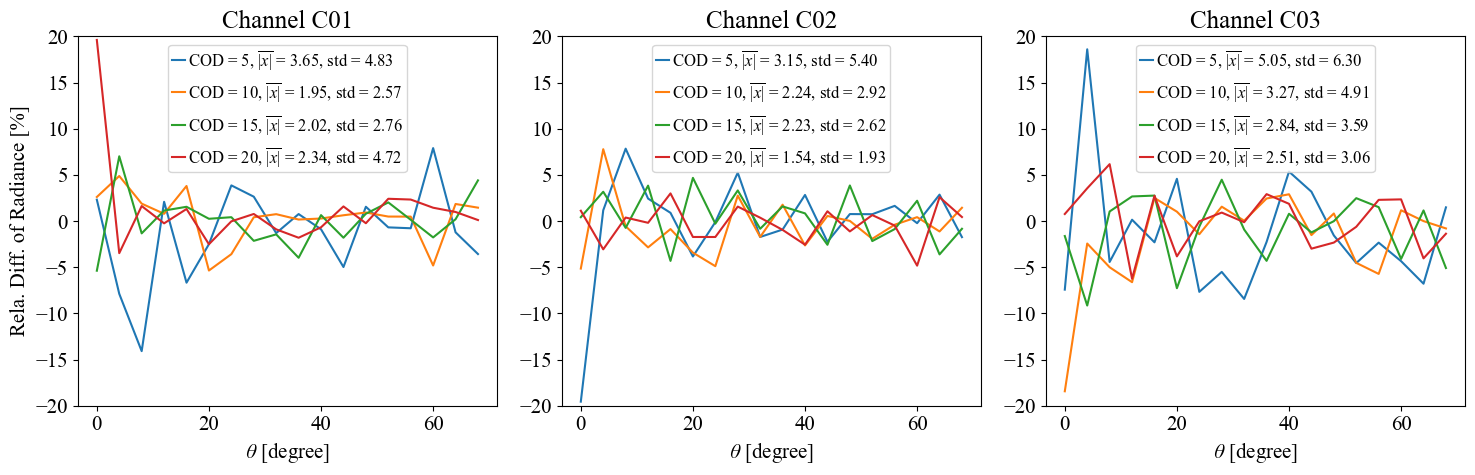

In [48]:
COD_v = np.array([5,10,15,20])
bandmode_v = ['fullspectrum','channels']
d_th = 2*2
bins_theta = np.arange(0, 91, d_th)
# Create a figure with 2x3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.ravel()  # Flatten the 2D array of axes for easier indexing
bin_scale = 2
channels = ['C{:02d}'.format(c) for c in range(1, 3 + 1)]
# Loop through each channel
for ch_idx, channel in enumerate(channels):
    for iCOD in COD_v:
        fdir = "./GOES_data/RTM/" 
        filename = '/'+ f'uwxyzr_COD={iCOD}_th0=32_Ta=299_RH=61.npy'
        file_dir = "./GOES_data/"
        
        for bandmode in bandmode_v:
            file_ = fdir + bandmode + filename
            results = np.load(file_, allow_pickle=True).item()
            uw_rxyz_M=results.get('uw_rxyz_M')
            
            dnu = 3
            nu = np.arange(2500, 35000, dnu)
            if bandmode == 'fullspectrum':
                nu_input = nu
            else:
                channel_6c = ['C{:02d}'.format(c) for c in range(1, 6 + 1)]
                nu_input = goes_calinu(nu, channel_6c, file_dir, dnu=3)

            data = np.genfromtxt('data/profiles/SolarTOA.csv', delimiter=',')
            ref_lam = data[:, 0]
            ref_E = data[:, 1]
            ref_E_nu = -ref_E * ref_lam ** 2 / 1e4
            
            channel_number = int(channel[-2:])
            dirpath = file_dir+'GOES-R_ABI_FM2_SRF_CWG/'
            channel_srf = os.path.join(dirpath,
                'GOES-R_ABI_FM2_SRF_CWG_ch{}.txt'.format(channel_number))
            calibration = np.genfromtxt(channel_srf, skip_header=2)
            calibration_nu = calibration[:, 1]
            calibration_srf = calibration[:, 2]
            nu_channel = goes_calinu(nu, [channel], file_dir, dnu=3)
            
            calibration_nu = calibration_nu[::-1]
            calibration_srf = calibration_srf[::-1]
            
            F_dw_os_channel = -np.interp(-nu_channel, -1e4 / ref_lam, ref_E_nu)
            srf = np.interp(nu_channel, calibration_nu, calibration_srf)
            F_dw_os_SRF = np.multiply(F_dw_os_channel, srf)

            nu_idx = np.nonzero(np.isin(nu_input,nu_channel))[0]
            result = [uw_rxyz_M[i] for i in nu_idx]

            if bandmode != 'channels':
                Rc_rtm,H_f = cal_mono_Intensity(result, Sun_Zen, nu_input[nu_idx], F_dw_os_SRF, local_zen, rela_azi,
                                                    is_flux=False, Norm=False, dirc='UW', bin_scale=bin_scale)
                H_theta=np.sum(H_f, axis=1)
            else:
                Rc_rtm,H_c = cal_mono_Intensity(result, Sun_Zen, nu_input[nu_idx], F_dw_os_SRF, local_zen, rela_azi,
                                                    is_flux=False, Norm=False, dirc='UW', bin_scale=bin_scale)
                H_theta_6c=np.sum(H_c, axis=1)
                # Plot in the corresponding subplot
                rela_d = (H_theta_6c-H_theta)/H_theta*100
                mean_val = np.mean(np.abs(rela_d[:-4]))
                std_val = np.std(rela_d[:-4])
                
                label_str = f'COD = {iCOD}, $\\overline{{|x|}}$ = {mean_val:.2f}, std = {std_val:.2f}'
                axs[ch_idx].plot(bins_theta[:-5], rela_d[:-4], label=label_str)
    
    # Set labels and title for each subplot
    if ch_idx == 0:
        axs[ch_idx].set_ylabel('Rela. Diff. of Radiance [%]')
    axs[ch_idx].set_xlabel(r'$\theta$ [degree]')
    #axs[ch_idx].set_ylabel('Rela. Diff. of Radiance between full and 6c') #(W/m2/sr)
    axs[ch_idx].set_title(f'Channel {channel}')
    axs[ch_idx].legend(loc='upper center', prop={'size': 12}, handlelength=0.8, handletextpad=0.2, borderpad=0.2)
    axs[ch_idx].set_ylim(-20, 20)


# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('Intg_bin_theta=10_COD=[5,10,15,20]_uncertainty_linux.png', dpi=300, bbox_inches='tight')
plt.show()

### theta_bin = 8

In [50]:
bins_theta = np.arange(0, 91, 2*2*2)
print(bins_theta.shape)
print(bins_theta[:-4])
bins_phi = np.arange(0, 180, 5*2*2)
print(bins_phi.shape)

(12,)
[ 0  8 16 24 32 40 48 56]
(9,)


In [53]:
(1.4+1.76+1.65+2.08+2.6+3.2)/3

4.23

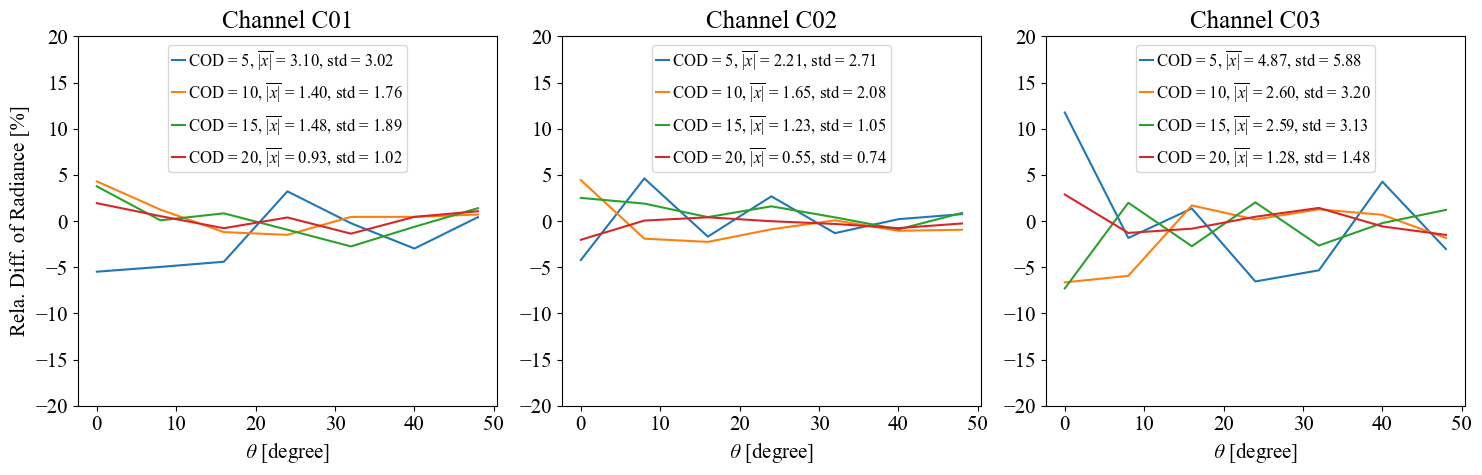

In [51]:
COD_v = np.array([5,10,15,20])
bandmode_v = ['fullspectrum','channels']
d_th = 2*2*2
bins_theta = np.arange(0, 91, d_th)
# Create a figure with 2x3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.ravel()  # Flatten the 2D array of axes for easier indexing
bin_scale = 4
channels = ['C{:02d}'.format(c) for c in range(1, 3 + 1)]
# Loop through each channel
for ch_idx, channel in enumerate(channels):
    for iCOD in COD_v:
        fdir = "./GOES_data/RTM/" 
        filename = '/'+ f'uwxyzr_COD={iCOD}_th0=32_Ta=299_RH=61.npy'
        file_dir = "./GOES_data/"
        
        for bandmode in bandmode_v:
            file_ = fdir + bandmode + filename
            results = np.load(file_, allow_pickle=True).item()
            uw_rxyz_M=results.get('uw_rxyz_M')
            
            dnu = 3
            nu = np.arange(2500, 35000, dnu)
            if bandmode == 'fullspectrum':
                nu_input = nu
            else:
                channel_6c = ['C{:02d}'.format(c) for c in range(1, 6 + 1)]
                nu_input = goes_calinu(nu, channel_6c, file_dir, dnu=3)

            data = np.genfromtxt('data/profiles/SolarTOA.csv', delimiter=',')
            ref_lam = data[:, 0]
            ref_E = data[:, 1]
            ref_E_nu = -ref_E * ref_lam ** 2 / 1e4
            
            channel_number = int(channel[-2:])
            dirpath = file_dir+'GOES-R_ABI_FM2_SRF_CWG/'
            channel_srf = os.path.join(dirpath,
                'GOES-R_ABI_FM2_SRF_CWG_ch{}.txt'.format(channel_number))
            calibration = np.genfromtxt(channel_srf, skip_header=2)
            calibration_nu = calibration[:, 1]
            calibration_srf = calibration[:, 2]
            nu_channel = goes_calinu(nu, [channel], file_dir, dnu=3)
            
            calibration_nu = calibration_nu[::-1]
            calibration_srf = calibration_srf[::-1]
            
            F_dw_os_channel = -np.interp(-nu_channel, -1e4 / ref_lam, ref_E_nu)
            srf = np.interp(nu_channel, calibration_nu, calibration_srf)
            F_dw_os_SRF = np.multiply(F_dw_os_channel, srf)

            nu_idx = np.nonzero(np.isin(nu_input,nu_channel))[0]
            result = [uw_rxyz_M[i] for i in nu_idx]

            if bandmode != 'channels':
                Rc_rtm,H_f = cal_mono_Intensity(result, Sun_Zen, nu_input[nu_idx], F_dw_os_SRF, local_zen, rela_azi,
                                                    is_flux=False, Norm=False, dirc='UW', bin_scale=bin_scale)
                H_theta=np.sum(H_f, axis=1)
            else:
                Rc_rtm,H_c = cal_mono_Intensity(result, Sun_Zen, nu_input[nu_idx], F_dw_os_SRF, local_zen, rela_azi,
                                                    is_flux=False, Norm=False, dirc='UW', bin_scale=bin_scale)
                H_theta_6c=np.sum(H_c, axis=1)
                
                # Plot in the corresponding subplot
                rela_d = (H_theta_6c-H_theta)/H_theta*100
                mean_val = np.mean(np.abs(rela_d[:-4]))
                std_val = np.std(rela_d[:-4])
                
                label_str = f'COD = {iCOD}, $\\overline{{|x|}}$ = {mean_val:.2f}, std = {std_val:.2f}'
                axs[ch_idx].plot(bins_theta[:-5], rela_d[:-4], label=label_str)
    
    # Set labels and title for each subplot
    if ch_idx == 0:
        axs[ch_idx].set_ylabel('Rela. Diff. of Radiance [%]')
    axs[ch_idx].set_xlabel(r'$\theta$ [degree]')
    #axs[ch_idx].set_ylabel('Rela. Diff. of Radiance between full and 6c') #(W/m2/sr)
    axs[ch_idx].set_title(f'Channel {channel}')
    axs[ch_idx].legend(loc='upper center', prop={'size': 12}, handlelength=0.8, handletextpad=0.2, borderpad=0.2)
    axs[ch_idx].set_ylim(-20, 20)


# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('Intg_bin_theta=8_COD=[5,10,15,20]_uncertainty_linux.png', dpi=300, bbox_inches='tight')
plt.show()

# Bundle number

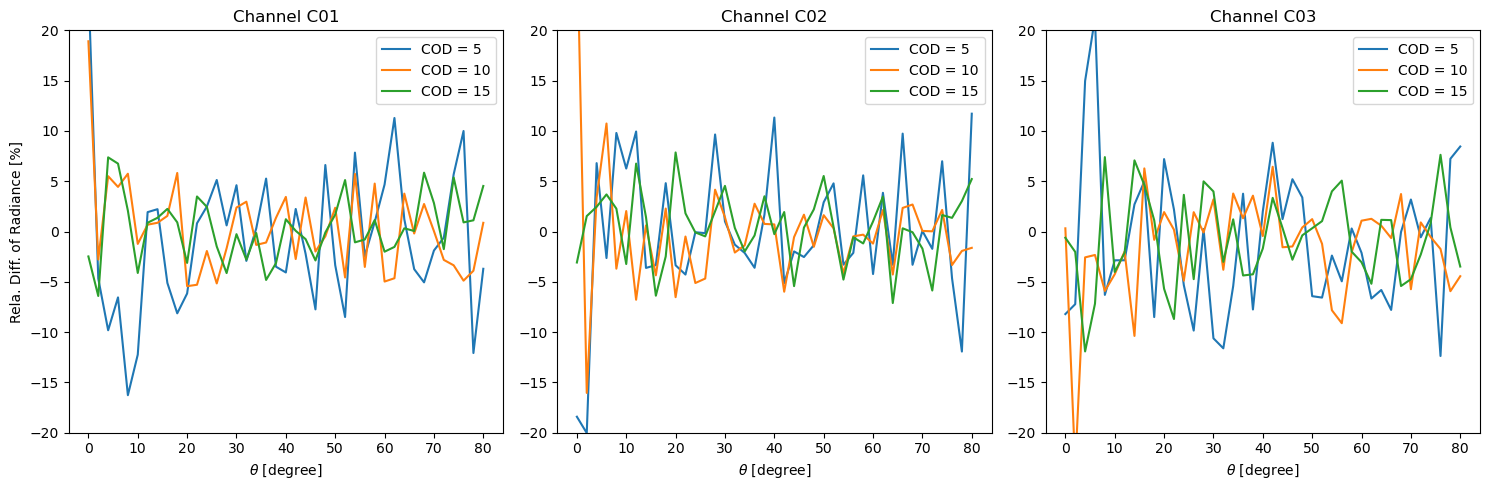

In [6]:
COD_v = np.array([5,10,15])
bandmode_v = ['fullspectrum','channels']
d_th = 2
bins_theta = np.arange(0, 91, d_th)
# Create a figure with 2x3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.ravel()  # Flatten the 2D array of axes for easier indexing
channels = ['C{:02d}'.format(c) for c in range(1, 3 + 1)]
N_bundles = 1000
# Loop through each channel
for ch_idx, channel in enumerate(channels):
    for iCOD in COD_v:
        fdir = "./GOES_data/RTM/" 
        filename = '/'+ f'uwxyzr_COD={iCOD}_th0=32_Ta=299_RH=61.npy'
        file_dir = "./GOES_data/"
        
        for bandmode in bandmode_v:
            file_ = fdir + bandmode + filename
            results = np.load(file_, allow_pickle=True).item()
            uw_rxyz_M=results.get('uw_rxyz_M')
            
            dnu = 3
            nu = np.arange(2500, 35000, dnu)
            if bandmode == 'fullspectrum':
                nu_input = nu
            else:
                channel_6c = ['C{:02d}'.format(c) for c in range(1, 6 + 1)]
                nu_input = goes_calinu(nu, channel_6c, file_dir, dnu=3)

            data = np.genfromtxt('data/profiles/SolarTOA.csv', delimiter=',')
            ref_lam = data[:, 0]
            ref_E = data[:, 1]
            ref_E_nu = -ref_E * ref_lam ** 2 / 1e4
            
            channel_number = int(channel[-2:])
            dirpath = file_dir+'GOES-R_ABI_FM2_SRF_CWG/'
            channel_srf = os.path.join(dirpath,
                'GOES-R_ABI_FM2_SRF_CWG_ch{}.txt'.format(channel_number))
            calibration = np.genfromtxt(channel_srf, skip_header=2)
            calibration_nu = calibration[:, 1]
            calibration_srf = calibration[:, 2]
            nu_channel = goes_calinu(nu, [channel], file_dir, dnu=3)
            
            calibration_nu = calibration_nu[::-1]
            calibration_srf = calibration_srf[::-1]
            
            F_dw_os_channel = -np.interp(-nu_channel, -1e4 / ref_lam, ref_E_nu)
            srf = np.interp(nu_channel, calibration_nu, calibration_srf)
            F_dw_os_SRF = np.multiply(F_dw_os_channel, srf)

            nu_idx = np.nonzero(np.isin(nu_input,nu_channel))[0]
            result = [uw_rxyz_M[i] for i in nu_idx]

            if bandmode != 'channels':
                Rc_rtm,H_f = cal_mono_Intensity(result, Sun_Zen, nu_input[nu_idx], F_dw_os_SRF, local_zen, rela_azi,
                                                    N_bundles,is_flux=False, Norm=False, dirc='UW')
                H_theta=np.sum(H_f, axis=1)
            else:
                Rc_rtm, H_c = cal_mono_Intensity(result, Sun_Zen, nu_input[nu_idx], F_dw_os_SRF, local_zen, rela_azi,
                                                    N_bundles,is_flux=False, Norm=False, dirc='UW')
                H_theta_6c=np.sum(H_c, axis=1)
                
                # Plot in the corresponding subplot
                rela_d = (H_theta_6c-H_theta)/H_theta*100
                axs[ch_idx].plot(bins_theta[:-5], rela_d[:-4], label=f'COD = {iCOD}')
    
    # Set labels and title for each subplot
    if ch_idx == 0:
        axs[ch_idx].set_ylabel('Rela. Diff. of Radiance [%]')  #(W/m2/sr)
    axs[ch_idx].set_xlabel(r'$\theta$ [degree]')
    #axs[ch_idx].set_ylabel('Rela. Diff. of Radiance between full and 6c') #(W/m2/sr)
    axs[ch_idx].set_title(f'Channel {channel}')
    axs[ch_idx].legend()
    axs[ch_idx].set_ylim(-20, 20)


# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('Intg_bin_theta=10_COD=[5,10,15]_uncertainty_macos_Nb=1000.png', dpi=300, bbox_inches='tight')
plt.show()

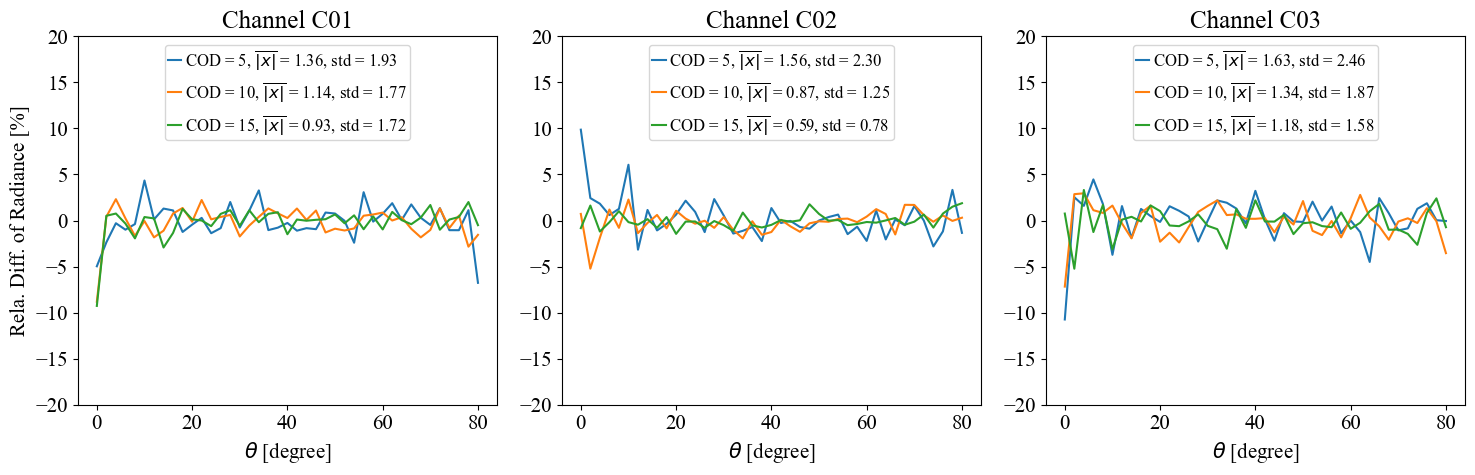

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import os

COD_v = np.array([5, 10, 15])
bandmode_v = ['fullspectrum', 'channels']
d_th = 2
bins_theta = np.arange(0, 91, d_th)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.ravel()
channels = ['C{:02d}'.format(c) for c in range(1, 3 + 1)]
N_bundles = 10000
font = 10  # Define base font size

for ch_idx, channel in enumerate(channels):
    for iCOD in COD_v:
        fdir = "./GOES_data/RTM_10000/"
        filename = '/' + f'uwxyzr_COD={iCOD}_th0=32_Ta=299_RH=61.npy'
        file_dir = "./GOES_data/"

        for bandmode in bandmode_v:
            file_ = fdir + bandmode + filename
            results = np.load(file_, allow_pickle=True).item()
            uw_rxyz_M = results.get('uw_rxyz_M')

            dnu = 3
            nu = np.arange(2500, 35000, dnu)
            if bandmode == 'fullspectrum':
                nu_input = nu
            else:
                channel_6c = ['C{:02d}'.format(c) for c in range(1, 6 + 1)]
                nu_input = goes_calinu(nu, channel_6c, file_dir, dnu=3)

            data = np.genfromtxt('data/profiles/SolarTOA.csv', delimiter=',')
            ref_lam = data[:, 0]
            ref_E = data[:, 1]
            ref_E_nu = -ref_E * ref_lam ** 2 / 1e4

            channel_number = int(channel[-2:])
            dirpath = file_dir + 'GOES-R_ABI_FM2_SRF_CWG/'
            channel_srf = os.path.join(dirpath, f'GOES-R_ABI_FM2_SRF_CWG_ch{channel_number}.txt')
            calibration = np.genfromtxt(channel_srf, skip_header=2)
            calibration_nu = calibration[:, 1][::-1]
            calibration_srf = calibration[:, 2][::-1]

            nu_channel = goes_calinu(nu, [channel], file_dir, dnu=3)
            F_dw_os_channel = -np.interp(-nu_channel, -1e4 / ref_lam, ref_E_nu)
            srf = np.interp(nu_channel, calibration_nu, calibration_srf)
            F_dw_os_SRF = np.multiply(F_dw_os_channel, srf)

            nu_idx = np.nonzero(np.isin(nu_input, nu_channel))[0]
            result = [uw_rxyz_M[i] for i in nu_idx]

            if bandmode != 'channels':
                Rc_rtm, H_f = cal_mono_Intensity(result, Sun_Zen, nu_input[nu_idx], F_dw_os_SRF, local_zen, rela_azi,
                                                 N_bundles, is_flux=False, Norm=False, dirc='UW')
                H_theta = np.sum(H_f, axis=1)
            else:
                Rc_rtm, H_c = cal_mono_Intensity(result, Sun_Zen, nu_input[nu_idx], F_dw_os_SRF, local_zen, rela_azi,
                                                 N_bundles, is_flux=False, Norm=False, dirc='UW')
                H_theta_6c = np.sum(H_c, axis=1)
                rela_d = (H_theta_6c - H_theta) / H_theta * 100

                mean_val = np.mean(np.abs(rela_d[:-4]))
                std_val = np.std(rela_d[:-4])
                
                label_str = f'COD = {iCOD}, $\\overline{{|x|}}$ = {mean_val:.2f}, std = {std_val:.2f}'
                axs[ch_idx].plot(bins_theta[:-5], rela_d[:-4], label=label_str)

    if ch_idx == 0:
        axs[ch_idx].set_ylabel('Rela. Diff. of Radiance [%]')
    axs[ch_idx].set_xlabel(r'$\theta$ [degree]')
    axs[ch_idx].set_title(f'Channel {channel}')
    axs[ch_idx].legend(loc='upper center', prop={'size': 12}, handlelength=0.8, handletextpad=0.2, borderpad=0.2)
    axs[ch_idx].set_ylim(-20, 20)

plt.tight_layout()
plt.savefig('Intg_bin_theta=10_COD=[5,10,15]_uncertainty_macos_Nb=10000.png', dpi=300, bbox_inches='tight')
plt.show()


# faster update the H  ?  do not come up with yet

In [163]:
from fun_nearealtime_RTM import nearealtime_RTM
channels=['C01', 'C02', 'C03', 'C04', 'C05', 'C06']
COD_v = np.array([10]) #5,10,15])
#Sun_Zen = 60
for Sun_Zen in [30]:#0,15,32,45,60]:
    N_bundles = 10000
    for iCOD in COD_v:
        bandmode = 'GOES' # GOES, full
        COD_guess = iCOD
        Rc_rtm = nearealtime_RTM(Sun_Zen, local_zen, rela_azi, COD_guess, T_a, RH, 
                                     channels, file_dir=data_dir,bandmode=bandmode,N_bundles=N_bundles)

File uwxyzr_COD=10_th0=30_Ta=299_RH=61.npy not found. Running RTM...
Start MonteCarlo once.
CoeffM,nu= 2509
CPU time: 70.61147618293762


In [2]:
def cal_mono_Intensity(rxyz_M, theta0, nu, F_dw_os, local_zen, rela_azi, N_bundles=1000,
                       is_flux=False, Norm=False, dirc='UW', bin_scale=1):  # Z_csky
    """
    bins_theta: local zenith angle
    bin_phi: relative difference between the angle of solar azimuth and local zimuth
    solid anlge (bin_theta,bin_phi) determined to the intensity at an angle of (satellite local solar).
    rxyz_M : the vector of each photon fall on the ground. Each band saved many photons, 
            we sum the number of photon, multiple with ratio to get  the flux.
    F_dw_os: the downwelling flux at TOA on each nu
    """
    theta0 = theta0 / 180 * math.pi
    phi0 = 0 / 180 * math.pi

    # bin_scale = 1
    d_th = 2 * bin_scale
    d_phi = 5 * bin_scale
    # GOES solar zenith 45, local zenith angle 45, relative azimuth difference angle 45
    bins_theta = np.arange(0, 91, d_th)
    # symmetric, so we change (-180, 180) to (0, 180)
    bins_phi = np.arange(-180, 181, d_phi)
    #bins_phi = np.hstack((np.arange(0, 170 + 5, 5), np.arange(170, 180 + 1, 1)))
    fw_rx, fw_ry, fw_rz, uw_rx, uw_ry, uw_rz = [np.zeros((N_bundles + 10, len(nu))) * np.nan for _ in range(6)]
    H = np.zeros((len(bins_theta) - 1, len(bins_phi) - 1))
    for i in range(len(rxyz_M)):
        fw_rxyz = rxyz_M[i]
        N_dw = len(fw_rxyz)
        fw_rx[0:N_dw, i] = np.array([x[0] for x in fw_rxyz])
        fw_ry[0:N_dw, i] = np.array([x[1] for x in fw_rxyz])
        fw_rz[0:N_dw, i] = np.array([x[2] for x in fw_rxyz])
        if dirc == 'UW':
            theta_v, phi_v = theta_phi(fw_rx[:, i], fw_ry[:, i], fw_rz[:, i])
        else:  # DW
            theta_v, phi_v = theta_phi(fw_rx[:, i], fw_ry[:, i], -fw_rz[:, i])
        ind = np.isnan(phi_v)
        theta_v = theta_v[~ind]
        phi_v = phi_v[~ind] - phi0
        phi_v[phi_v > math.pi] -= 2 * math.pi
        H_i, xedges, yedges = np.histogram2d(np.rad2deg(theta_v), np.rad2deg(phi_v), bins=(bins_theta, bins_phi))
        H += H_i * np.cos(theta0) * F_dw_os[i] * 3 / N_bundles
    theta_, phi_ = np.meshgrid(xedges[0:-1], yedges[0:-1])
    theta_idx, phi_idx = find_bin_indices(local_zen, rela_azi, 'both')
    F = np.sum(H)
    if not is_flux: # approximation of domega
        ths = np.deg2rad(theta_.T + d_th / 2)
        #print(np.sum(H))
        H /= 0.5 * np.sin(2 * ths)  # I=dF/dw, dF = H/cos(ths), dw=sin(ths)d_thd_phi. 0.5*sin(2ths)=cos(ths)sin(ths)
    H /= np.deg2rad(d_th) * np.deg2rad(d_phi)  # per solid angle, in the direction of beam
    R = H*np.pi / F
        # Integrated intensity over phi, for each theta bin
        # H_theta = np.sum(H, axis=1) * np.deg2rad(d_phi)
        # H_theta_6c = np.sum(H, axis=1) * np.deg2rad(d_phi)
    return R[theta_idx, phi_idx],R

In [20]:
d_theta=2
d_phi=5
theta_edges =  np.arange(0, 91, d_th)
theta_centers = np.radians(theta_edges[:-1] + d_theta / 2)
cos_theta = np.cos(theta_centers)
sin_theta = np.sin(theta_centers)
sin_theta_2d = sin_theta[:, np.newaxis]
cos_theta_2d = cos_theta[:, np.newaxis]

dtheta_rad = np.radians(d_theta)
dphi_rad = np.radians(d_phi)

## check nor

In [4]:
def check_normalization(R_nor, d_theta=2, d_phi=5):
    """
    Check if H_nor is properly normalized.

    Returns:
        integral_value (float): Should be ~1.0 if normalized.
    """
    n_theta, n_phi = R_nor.shape

    # Bin centers in radians
    theta_edges = np.linspace(0, 90, n_theta + 1)
    theta_centers = np.radians(theta_edges[:-1] + d_theta / 2)
    cos_theta = np.cos(theta_centers)
    sin_theta = np.sin(theta_centers)
    sin_theta_2d = sin_theta[:, np.newaxis]
    cos_theta_2d = cos_theta[:, np.newaxis]

    dtheta_rad = np.radians(d_theta)
    dphi_rad = np.radians(d_phi)

    # Compute the integral
    integral_value = np.sum(R_nor * cos_theta_2d* sin_theta_2d) * dtheta_rad * dphi_rad
    return integral_value

In [6]:
import matplotlib.colors as mcolors
def ghi2d_show(F_ghi_2d, channel, ang,vmax, logscale=True):
    font = 15
    fontfml = 'Times New Roman'
    plt.rcParams['font.size'] = font
    plt.rcParams['font.family'] = fontfml
    d_th = 2
    d_phi = 5
    bins_theta = np.arange(0, 91, d_th)
    bins_phi = np.arange(-180, 181, d_phi)
    
    norm = mcolors.Normalize(vmin=0, vmax=vmax)

    # Create a new figure with defined size
    fig = plt.figure(figsize=(5, 4))
    gs1 = gridspec.GridSpec(1, 1)
    gs1.update(wspace=-0.1, hspace=0.0)

    # Apply logarithmic scaling if needed
    if logscale:
        Z = np.log10(F_ghi_2d.T + 1.0)
    else:
        Z = F_ghi_2d.T

    # Create the subplot
    ax1 = fig.add_subplot(gs1[0, 0])

    # The extent parameter defines the bounding box in data coordinates
    extent = [bins_theta[0], bins_theta[-1], bins_phi[0], bins_phi[-1]]

    # Display the image with the appropriate bin edges
    im = ax1.imshow(Z, cmap='Spectral_r', origin="lower", norm=norm,extent=extent)

    # Set x and y labels
    ax1.set_xlabel('Theta (degrees)')
    ax1.set_ylabel('Phi (degrees)')

    # Set ticks for x-axis based on the bins
    ax1.set_xticks(np.arange(0, 90 + 30, 30))  # Set ticks at each bin edge
    ax1.set_yticks(np.arange(-180, 180 + 30, 30))  # Set ticks at each bin edge

    # Add a color bar
    cbar1 = plt.colorbar(im)
    # Add a color bar with custom ticks
    cbar1.set_ticks(np.arange(0, vmax, 0.05))  # Set ticks from 0 to 2 with a step of 0.5
    if logscale:
        cbar1.set_label('log$_{10}$ of intensity [W m$^{-2}$ sr$^{-1}$]', rotation=90,
                        labelpad=0, fontsize=font, family=fontfml)  # ****
    else:
        cbar1.set_label('Intensity [W m$^{-2}$ sr$^{-1}$]', rotation=90,
                        labelpad=0, fontsize=font, family=fontfml)
    cbar1.ax.tick_params(labelsize=font, labelcolor='black')  # ****
    # Show the plot
    fig_dir = "./figures/angular_distribution_unstable_test/"
    plt.savefig(fig_dir+f'Intensity_{channel}_Z={ang}.png', dpi=300, bbox_inches='tight')
    plt.show()
    return None

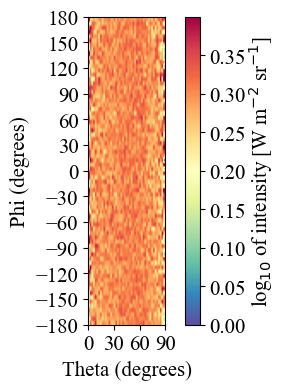

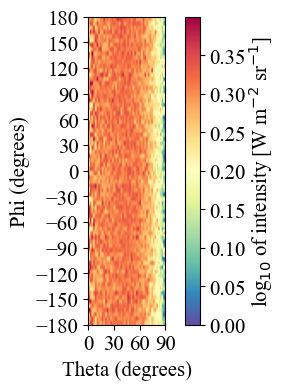

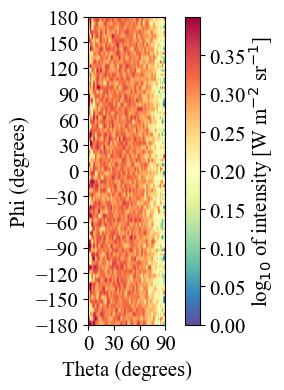

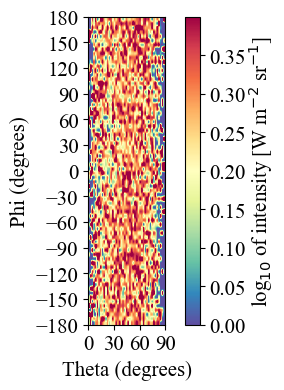

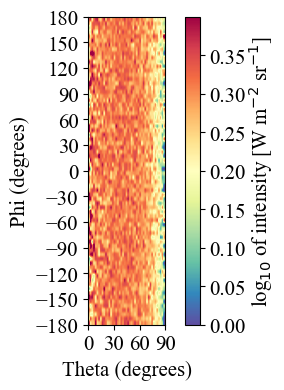

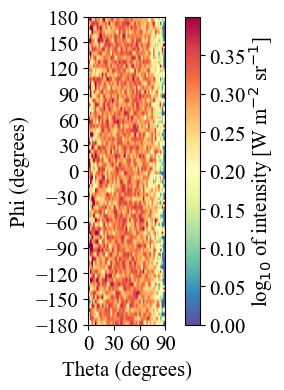

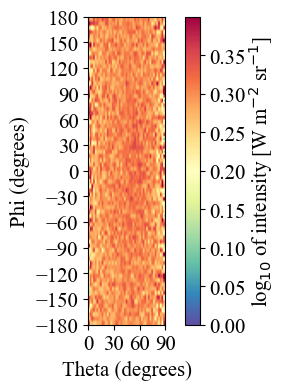

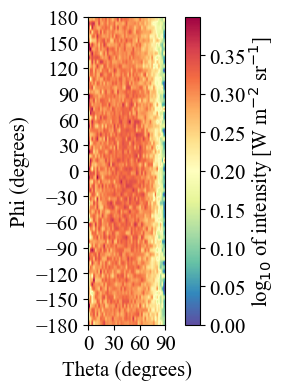

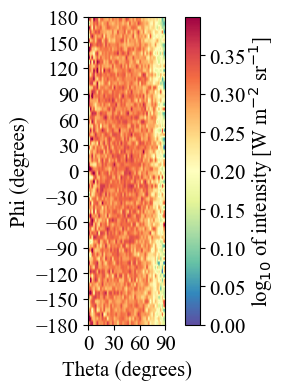

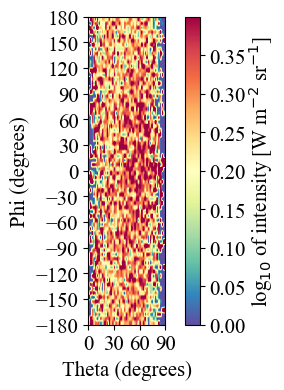

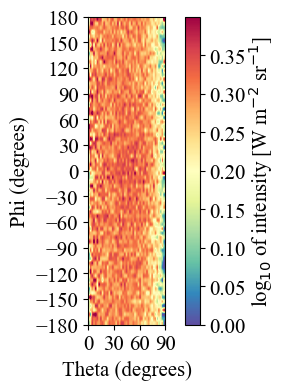

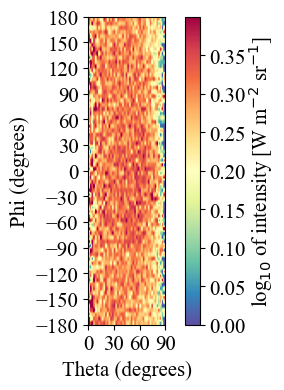

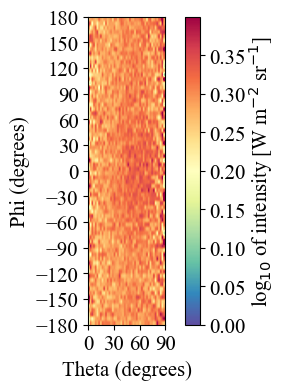

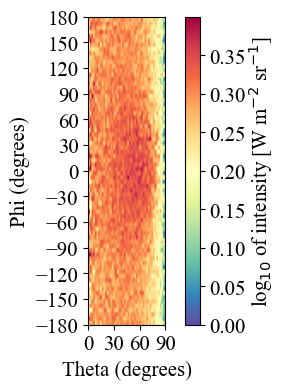

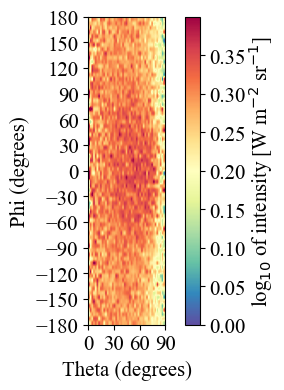

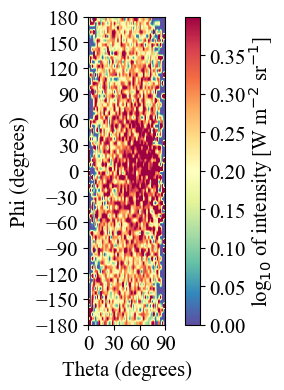

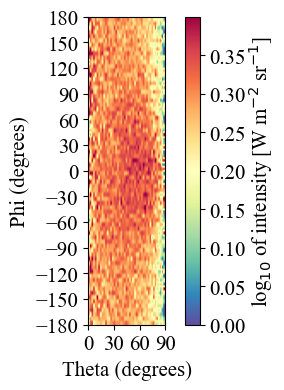

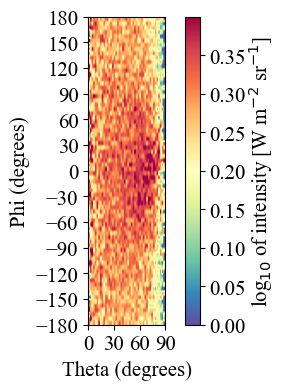

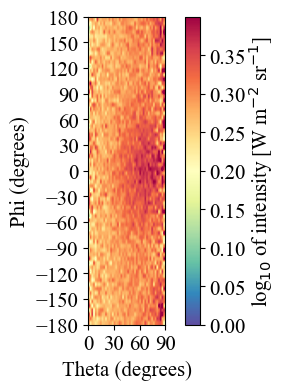

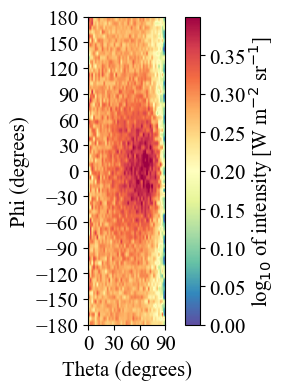

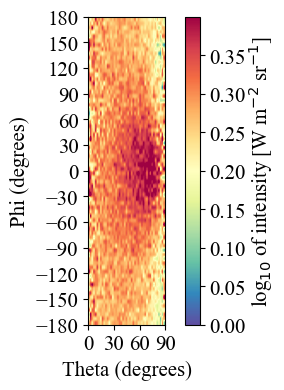

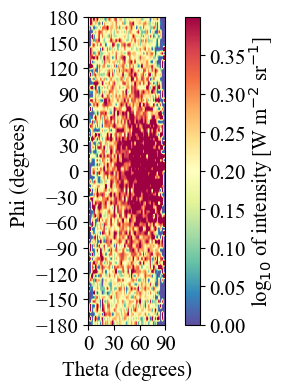

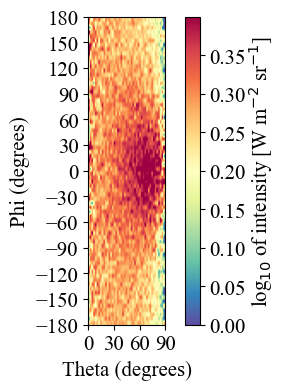

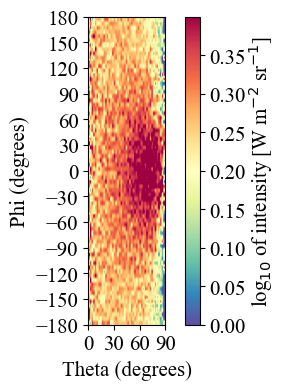

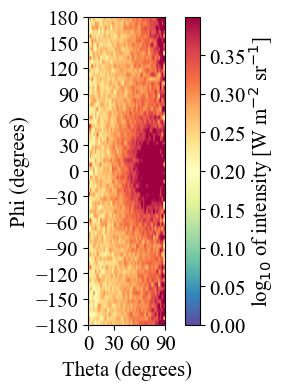

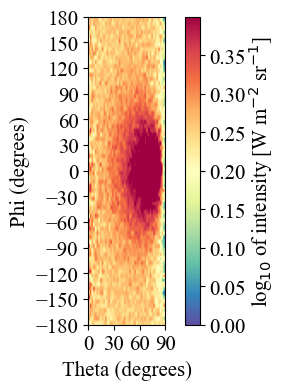

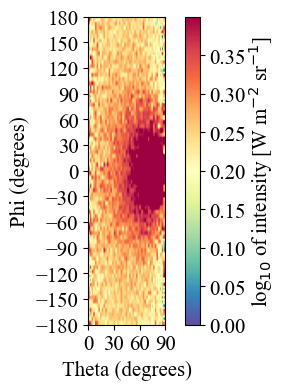

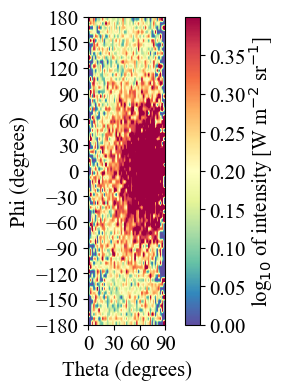

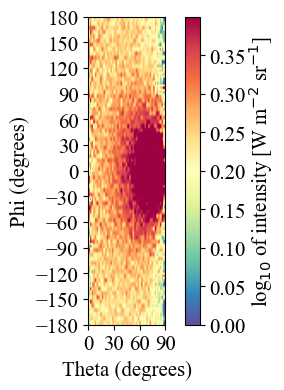

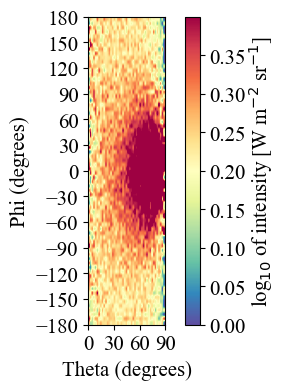

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os

COD_v = np.array([10])
bandmode_v = ['channels']
d_th = 2
bins_theta = np.arange(0, 91, d_th)
# fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# axs = axs.ravel()
channels = ['C{:02d}'.format(c) for c in range(1, 6 + 1)]
#channels = ['C02']
N_bundles = 10000
font = 10  # Define base font size
Ang_D = []
for ang in [0,15,30,45,60]:
    for ch_idx, channel in enumerate(channels):
        for iCOD in COD_v:
            fdir = "/mnt/dengnan/RTM_10000/"
            filename = '/' + f'uwxyzr_COD={iCOD}_th0={ang}_Ta=299_RH=61.npy'
            file_dir = "./GOES_data/"

            for bandmode in bandmode_v:
                file_ = fdir + bandmode + filename
                results = np.load(file_, allow_pickle=True).item()
                uw_rxyz_M = results.get('uw_rxyz_M')

                dnu = 3
                nu = np.arange(2500, 35000, dnu)
                if bandmode == 'fullspectrum':
                    nu_input = nu
                else:
                    channel_6c = ['C{:02d}'.format(c) for c in range(1, 6 + 1)]
                    nu_input = goes_calinu(nu, channel_6c, file_dir, dnu=3)

                data = np.genfromtxt('data/profiles/SolarTOA.csv', delimiter=',')
                ref_lam = data[:, 0]
                ref_E = data[:, 1]
                ref_E_nu = -ref_E * ref_lam ** 2 / 1e4

                channel_number = int(channel[-2:])
                dirpath = file_dir + 'GOES-R_ABI_FM2_SRF_CWG/'
                channel_srf = os.path.join(dirpath, f'GOES-R_ABI_FM2_SRF_CWG_ch{channel_number}.txt')
                calibration = np.genfromtxt(channel_srf, skip_header=2)
                calibration_nu = calibration[:, 1][::-1]
                calibration_srf = calibration[:, 2][::-1]

                nu_channel = goes_calinu(nu, [channel], file_dir, dnu=3)
                F_dw_os_channel = -np.interp(-nu_channel, -1e4 / ref_lam, ref_E_nu)
                srf = np.interp(nu_channel, calibration_nu, calibration_srf)
                F_dw_os_SRF = np.multiply(F_dw_os_channel, srf)

                nu_idx = np.nonzero(np.isin(nu_input, nu_channel))[0]
                result = [uw_rxyz_M[i] for i in nu_idx]

                if bandmode == 'channels':
                    Rc_rtm, R_c = cal_mono_Intensity(result, Sun_Zen, nu_input[nu_idx], F_dw_os_SRF, 
                                                    local_zen, rela_azi,
                                                    N_bundles, is_flux=False, Norm=True, dirc='UW')
                    is_norm = check_normalization(R_c)/np.pi
                    if not np.isclose(is_norm, 1.0, rtol=1e-5):
                        print('is_norm:', is_norm)
                    vmax=0.4
                    ghi2d_show(R_c, channel, ang, vmax, logscale=True)
                    #H_theta = np.sum(H_c, axis=1)
                Ang_D.append(R_c)

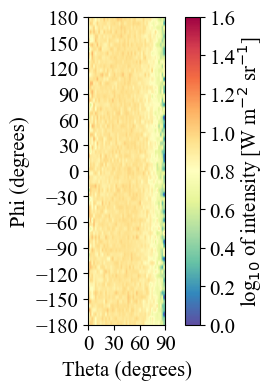

In [69]:
ghi2d_show(H_c,channel,ang, logscale=True)

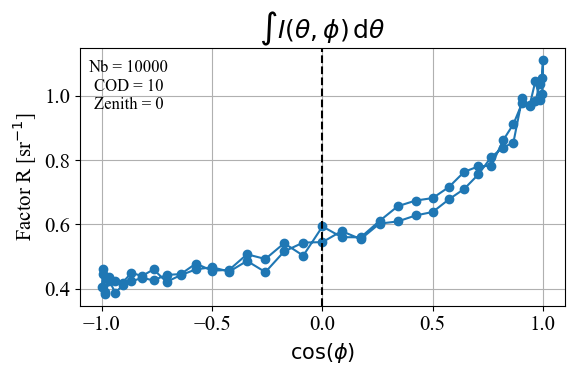

Mean intensity: 6.2351e-01
Standard deviation: 2.1008e-01
Relative std deviation: 33.69%


In [152]:
# H_c.shape = (45,72)
# bins_theta[:-1].shape = 45

d_phi = 5
d_theta = 2
bins_phi = np.arange(-180, 181, d_phi)

# Integrate intensity over theta axis → get 1D function of phi
H_phi = np.sum(H_c.T, axis=1) * np.deg2rad(d_theta)  # assumes d_theta = 2 degrees
AngD = [] 
#Ang = np.array([0, 15, 30, 45])
AngD.append(H_phi)
# Plotting
cos = True  # set to True if you want cos(phi) instead of phi
font = 12

plt.figure(figsize=(6, 4))
ax = plt.gca()  # get current axis

if cos:
    x = np.cos(np.deg2rad(bins_phi[:-1]))
    ax.plot(x, H_phi, 'o-')
    ax.set_xlabel(r'$\cos(\phi)$')
else:
    ax.plot(bins_phi[:-1], H_phi, 'o-')
    ax.set_xlabel(r'$\phi$ [degrees]')
    ax.set_xticks(np.arange(-180, 181, 60))

ax.set_title(r'$\int I(\theta, \phi)\,\mathrm{d}\theta$')
#ax.set_ylabel(r'Intensity [W m$^{-2}$ sr$^{-1}$]')
ax.set_ylabel(r'Factor R [sr$^{-1}$]')
#ax.set_ylim(20, 30)
ax.axvline(0, color='black', linestyle='--')
ax.text(0.1, 0.85, f'Nb = {10000}\nCOD = 10\nZenith = 0', fontsize=font, ha='center', va='center', transform=ax.transAxes)
ax.grid(True)
plt.tight_layout()
plt.show()

# Stats to assess isotropy
mean_H = np.mean(H_phi)
std_H = np.std(H_phi)
rel_std = std_H / mean_H

print(f'Mean intensity: {mean_H:.4e}')
print(f'Standard deviation: {std_H:.4e}')
print(f'Relative std deviation: {rel_std:.2%}')

# theta

In [153]:
print(len(Ang_D))
Ang_D[0].shape

30


(45, 72)

In [154]:
F_dw_os_srf = np.load('./GOES_data/'+'F_dw_os_srf.npy')
F_dw_os_srf

array([ 74.87922869, 134.24362686,  33.70391083,   4.92360761,
        11.08340386,   3.52294571])

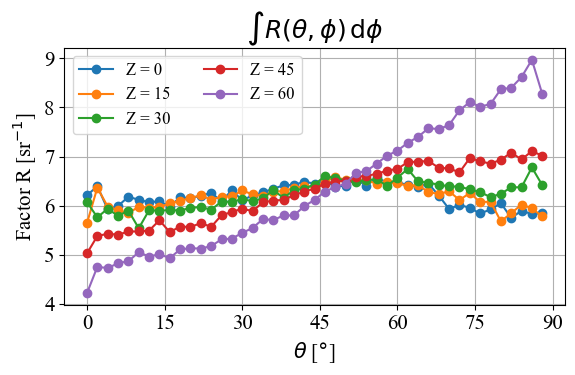

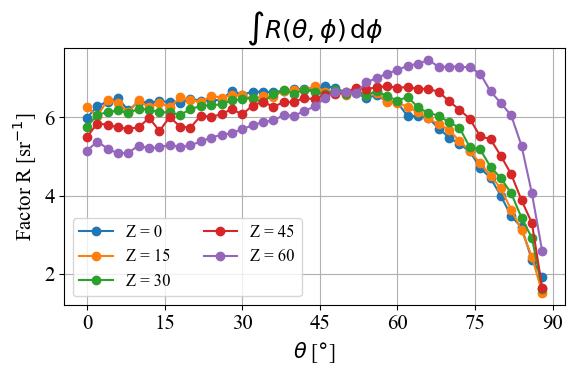

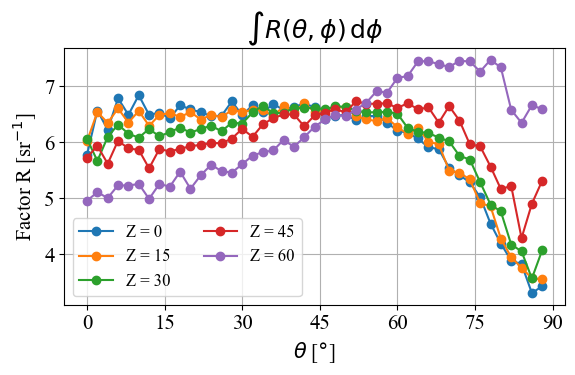

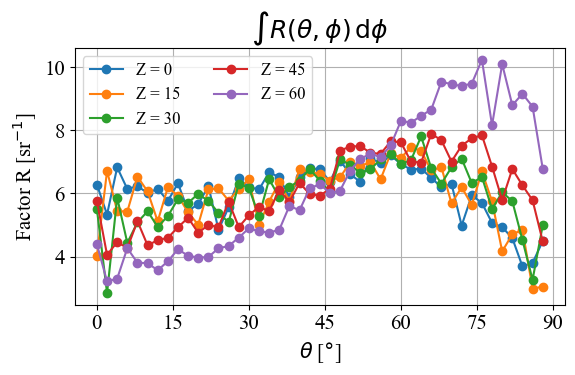

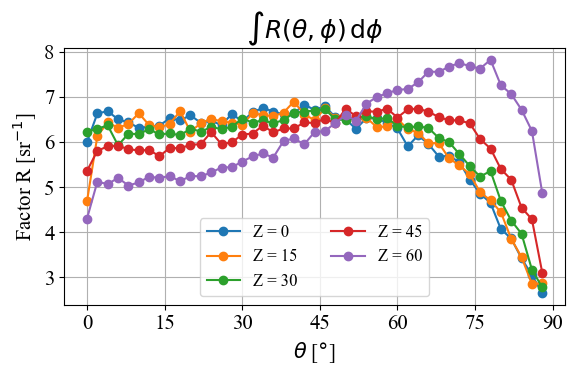

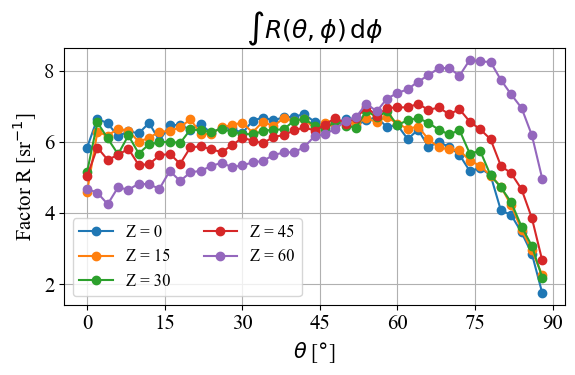

In [10]:
d_phi = 5
d_theta = 2
bins_theta = np.arange(0, 91, d_theta)

# Integrate intensity over theta axis → get 1D function of phi

# Plotting
cos = False# set to True if you want cos(phi) instead of phi
font = 12
Ang = np.array([0, 15, 30, 45, 60])
n_channels = 6

for c_idx, channel in enumerate(channels):
    plt.figure(figsize=(6, 4))
    ax = plt.gca()
    for i in range(5):
        # Extract values for this channel across all angles
        H_c =Ang_D[i * n_channels + c_idx]
        H_phi = np.sum(H_c, axis=1) * np.deg2rad(d_phi) #/ F_dw_os_srf[c_idx]  # assumes d_theta = 2 degrees
        if cos:
            x = np.cos(np.deg2rad(bins_theta[:-1]))
            ax.plot(x, H_phi, 'o-',label = f'Z = {Ang[i]}')
            ax.set_xlabel(r'$\cos(\theta)$')
        else:
            ax.plot(bins_theta[:-1], H_phi, 'o-',label = f'Z = {Ang[i]}')
            ax.set_xlabel(r'$\theta$ [$\degree$]')
            ax.set_xticks(np.arange(0, 90+15, 15))

    ax.set_title(r'$\int R(\theta, \phi)\,\mathrm{d}\phi$')
    #ax.set_ylabel(r'Intensity [W m$^{-2}$ sr$^{-1}$]')
    ax.set_ylabel(r'Factor R [sr$^{-1}$]')
    #ax.set_ylim(0, 140)
    #ax.axvline(0, color='black', linestyle='--')
    #ax.text(0.1, 0.9, f'Nb = {10000}\nCOD = 10', fontsize=font, ha='center', va='center', transform=ax.transAxes)
    ax.grid(True)
    ax.legend(loc='best', ncol=2, fontsize=font)
    plt.tight_layout()
    fig_dir = "./figures/angular_distribution_unstable_test/"
    plt.savefig(fig_dir+f'R_Intg_alongphi_{channel}.png', dpi=300, bbox_inches='tight')
    plt.show()

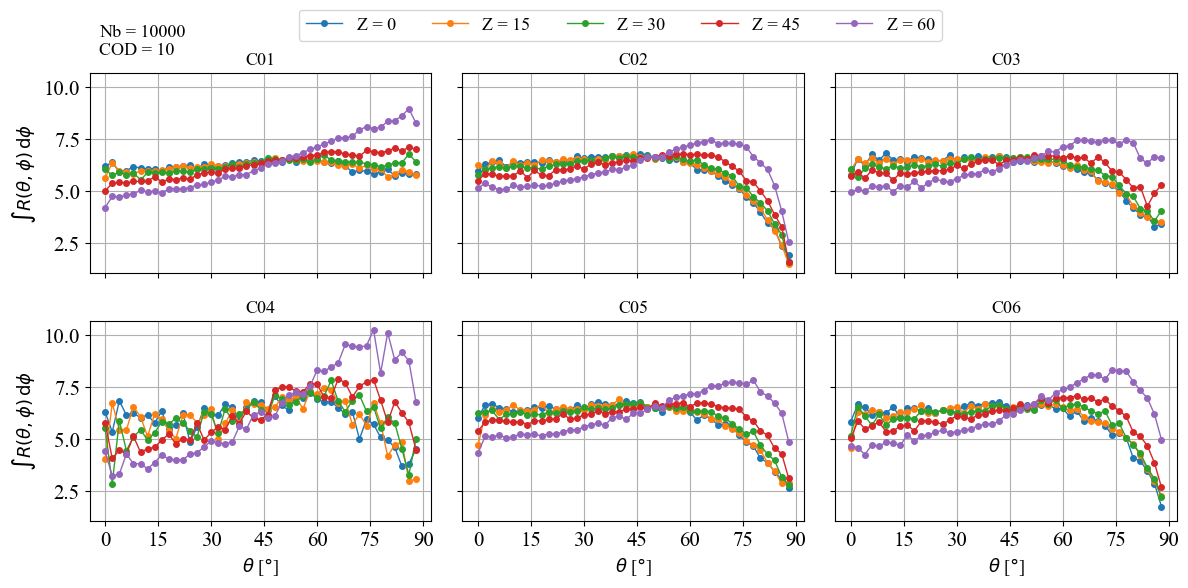

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# channels = ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6']
Ang = np.array([0, 15, 30, 45, 60])
n_channels = 6
n_angles = len(Ang)

d_phi = 5
d_theta = 2
bins_theta = np.arange(0, 91, d_theta)
cos = False
font = 13
Nb = 10000
COD = 10

fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)
axs = axs.flatten()

lines = []
labels = []

for c_idx, channel in enumerate(channels):
    ax = axs[c_idx]

    for i in range(n_angles):
        H_c = Ang_D[i * n_channels + c_idx]
        H_phi = np.sum(H_c, axis=1) * np.deg2rad(d_phi) # / F_dw_os_srf[c_idx]

        if cos:
            x = np.cos(np.deg2rad(bins_theta[:-1]))
            l, = ax.plot(x, H_phi, 'o-', label=f'Z = {Ang[i]}',linewidth=1,markersize=4)
        else:
            l, = ax.plot(bins_theta[:-1], H_phi, 'o-', label=f'Z = {Ang[i]}',linewidth=1,markersize=4)
            ax.set_xticks(np.arange(0, 91, 15))

        if c_idx == 0:
            lines.append(l)
            labels.append(f'Z = {Ang[i]}')

    ax.set_title(channel, fontsize=font)

    # Only show y-labels for axs[0] and axs[3]
    if c_idx in [0, 3]:
        ax.set_ylabel(r'$\int R(\theta, \phi)\,\mathrm{d}\phi$', fontsize=font)
        
    else:
        ax.set_ylabel('')

    # Only show x-labels for the bottom row (axs[3], [4], [5])
    if c_idx in [3, 4, 5]:
        if cos:
            ax.set_xlabel(r'$\cos(\theta)$', fontsize=font)
        else:
            ax.set_xlabel(r'$\theta$ [$\degree$]', fontsize=font)
    else:
        ax.set_xlabel('')

    ax.grid(True)

# Remove any unused axes
for i in range(len(channels), len(axs)):
    fig.delaxes(axs[i])

# Global title
#fig.suptitle(r'$\int R(\theta, \phi)\,\mathrm{d}\phi$', fontsize=16)

# Upper-left global text
fig.text(0.08, 0.96, f'Nb = {Nb}\nCOD = {COD}', fontsize=font,
         ha='left', va='top', transform=fig.transFigure)

# Legend in upper-right of whole figure
fig.legend(lines, labels, loc='upper right', ncol=n_angles, fontsize=font, bbox_to_anchor=(0.79,1))

plt.tight_layout(rect=[0, 0, 1,0.95])
plt.savefig('./figures/angular_distribution_unstable_test/R_Intg_alongphi_allchannels.png',
            dpi=300, bbox_inches='tight')
plt.show()

# phi

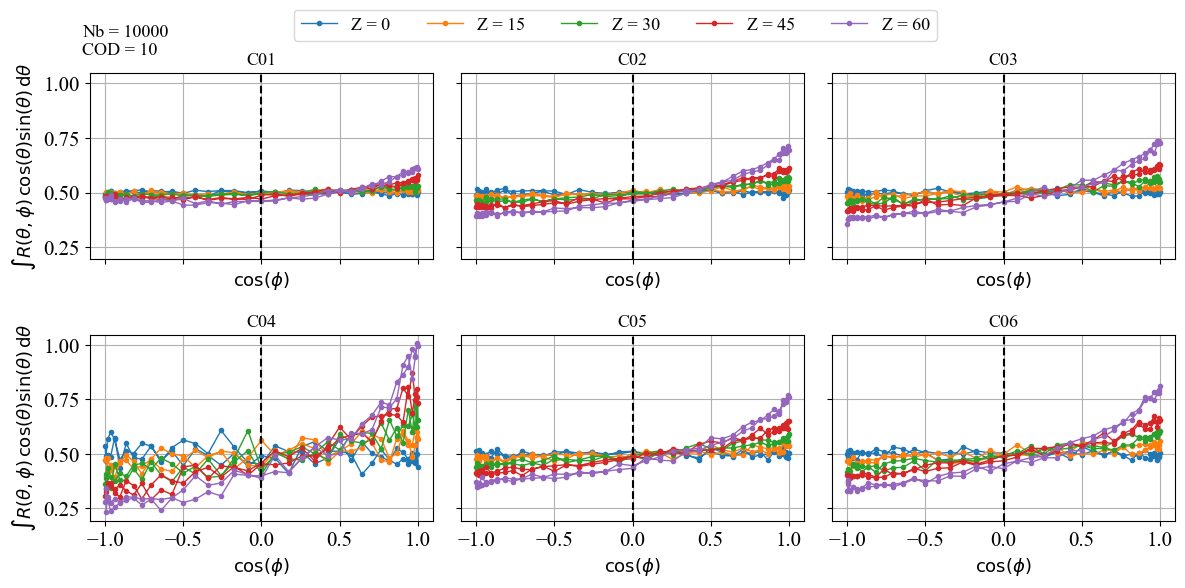

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
cos = True
font = 13
d_phi = 5
d_theta = 2
Nb = 10000
COD = 10

Ang = np.array([0, 15, 30, 45, 60])
n_angles = len(Ang)
n_channels = 6
bins_phi = np.arange(-180, 181, d_phi)

# Set up subplots for 6 channels
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)
axs = axs.flatten()

lines = []
labels = []

for c_idx, channel in enumerate(channels):
    ax = axs[c_idx]

    for i in range(n_angles):
        # Each H_c is (phi_bins, theta_bins)
        H_c = Ang_D[i * n_channels + c_idx]
        H = np.sum(H_c*cos_theta_2d*sin_theta_2d,axis=0)
        H_theta_intg = H.T * np.deg2rad(d_theta)# / F_dw_os_srf[c_idx]  # integrate over theta

        if cos:
            x = np.cos(np.deg2rad(bins_phi[:-1]))
            l, = ax.plot(x, H_theta_intg, 'o-', label=f'Z = {Ang[i]}', linewidth=1, markersize=3)
            ax.set_xlabel(r'$\cos(\phi)$', fontsize=font)
        else:
            l, = ax.plot(bins_phi[:-1], H_theta_intg, 'o-', label=f'Z = {Ang[i]}', linewidth=1, markersize=4)
            ax.set_xticks(np.arange(-180, 181, 60))

        if c_idx == 0:
            lines.append(l)
            labels.append(f'Z = {Ang[i]}')

    ax.set_title(channel, fontsize=font)

    # Only show y-labels for axs[0] and axs[3]
    if c_idx in [0, 3]:
        ax.set_ylabel(r'$\int R(\theta, \phi)\,\cos(\theta)\sin(\theta)\,\mathrm{d}\theta$', fontsize=font)

    # Only show x-labels for bottom row
    if c_idx in [3, 4, 5]:
        if cos:
            ax.set_xlabel(r'$\cos(\phi)$', fontsize=font)
        else:
            ax.set_xlabel(r'$\phi$ [$\degree$]', fontsize=font)

    ax.axvline(0, color='black', linestyle='--')
    ax.grid(True)

# Remove unused axes (if any)
for i in range(len(channels), len(axs)):
    fig.delaxes(axs[i])

# Global title
#fig.suptitle(r'$\int R(\theta, \phi)\,\cos(\theta)\sin(\theta)\,\mathrm{d}\theta$', fontsize=16)

# Global upper-left text
fig.text(0.07, 0.96, f'Nb = {Nb}\nCOD = {COD}', fontsize=font,
         ha='left', va='top', transform=fig.transFigure)

# Shared legend in upper-right of whole figure
fig.legend(lines, labels, loc='upper right', ncol=n_angles, fontsize=font, bbox_to_anchor=(0.79,1))

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('./figures/angular_distribution_unstable_test/R_Intg_alongtheta_allchannels_cosths.png',
           dpi=300, bbox_inches='tight')
plt.show()

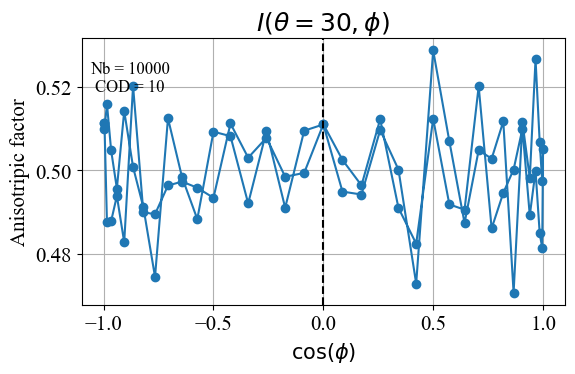

In [59]:
cos = True  # set to True if you want cos(phi) instead of phi
font = 12
bins_phi = np.arange(-180, 181, d_phi)
plt.figure(figsize=(6, 4))
ax = plt.gca()  # get current axis
Ang = np.array([0, 15, 30, 45, 60])
for i in range (4,5):
    H_c = Ang_D[i]
    H = np.sum(H_c*cos_theta_2d*sin_theta_2d,axis=0)
    H_theta_intg = H.T * np.deg2rad(d_theta)
    if cos:
        x = np.cos(np.deg2rad(bins_phi[:-1]))
        ax.plot(x, H_theta_intg, 'o-',label = f'Z = {Ang[i]}')
        ax.set_xlabel(r'$\cos(\phi)$')
    else:
        ax.plot(bins_phi[:-1], H_theta_intg, 'o-',label = f'Z = {Ang[i]}')
        ax.set_xlabel(r'$\phi$ [degrees]')
        ax.set_xticks(np.arange(-180, 181, 60))

ax.set_title(r'$I(\theta=30, \phi)$')
ax.set_ylabel(r'Intensity [W m$^{-2}$ sr$^{-1}$]')
ax.set_ylabel(r'Anisotripic factor')
#ax.set_ylim(20, 40)
ax.axvline(0, color='black', linestyle='--')
ax.text(0.1, 0.85, f'Nb = {10000}\nCOD = 10',
         fontsize=font, ha='center', va='center', transform=ax.transAxes)
ax.grid(True)
#ax.legend(loc='upper right', fontsize=font)
plt.tight_layout()
plt.show()

# Stats to assess isotropy
mean_H = np.mean(H_phi)
std_H = np.std(H_phi)
rel_std = std_H / mean_H

### temperature test

## independent test

$\int_0^{\pi/2} \int_0^{2\pi} R(\theta, \phi) \,\cos\theta \sin\theta \, d\phi \, d\theta = 1$

$R(\phi) = \int R(\theta, \phi)\,\cos(\theta)\sin(\theta)\,\mathrm{d}\theta$

$R(\theta) = \int R(\theta, \phi) d\phi $

$ R(\theta, \phi) ==  R(\theta) R(\phi) $

In [257]:
n_channels = 6
i = 3 # Ang=0,15,30,45,60
c_idx = 1 # channel2
H_c = Ang_D[i * n_channels + c_idx]

# integrate over theta
H_phi_intg = np.sum(H_c, axis=1) * np.deg2rad(d_phi)

# method 1
# integrate over theta
# H = np.sum(H_c*cos_theta_2d*sin_theta_2d,axis=0) #
# H_theta_intg = H.T * np.deg2rad(d_theta) 
# Example with verification
# result = np.outer(H_theta_intg, H_phi_intg)
# print(result.shape)  # Should print: (72, 45)

# # Verify specific elements
# print(result[0,0] == H_theta_intg[0] * H_phi_intg[0])  # Should be True
# print(result[71,44] == H_theta_intg[71] * H_phi_intg[44])  # Should be True

# method 2
H_theta = H_c / H_phi_intg[:, np.newaxis]
# smooth
# H_phi_intg is a 1D NumPy array
H_phi_intg_s = gaussian_filter1d(H_phi_intg, sigma=1)
H_theta_s = gaussian_filter1d(H_theta, sigma=1, axis=1, mode='reflect')
result = H_phi_intg_s[:, np.newaxis] * H_theta_s

In [319]:
# Save Ang_D list of matrices to a compressed .npz file
np.savez_compressed("Ang_D.npz", **{f"D{i}": mat for i, mat in enumerate(Ang_D)})

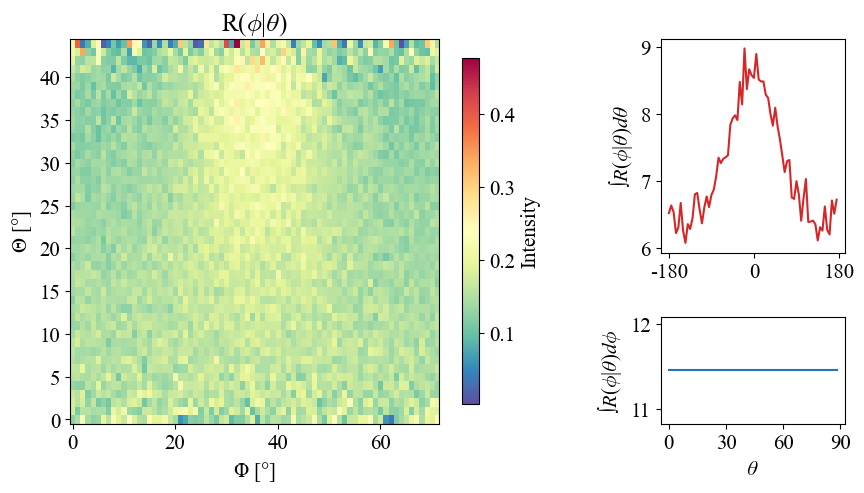

In [317]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# --- Dummy H_theta for example ---
# H_theta = np.random.rand(45, 72)  # shape (theta, phi)

# --- Font setup ---
font = 15
plt.rcParams['font.size'] = font
plt.rcParams['font.family'] = 'Times New Roman'

# --- Create figure with custom layout ---
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(2, 2, width_ratios=[2.5, 1], height_ratios=[2, 1])
gs.update(wspace=0.4, hspace=0.4)

# --- Figure 1: Heatmap ---
ax0 = fig.add_subplot(gs[:, 0])  # spans both rows
im = ax0.imshow(H_theta, cmap='Spectral_r', aspect='auto', origin='lower')
ax0.set_title(r"R$(\phi|\theta)$")
ax0.set_xlabel(r'$\Phi$ [°]')
ax0.set_ylabel(r'$\Theta$ [°]')
cbar = fig.colorbar(im, ax=ax0, shrink=0.9)
cbar.set_label("Intensity")

# --- Figure 2: Sum over φ (axis=1) ---
ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(np.sum(H_theta, axis=0), color='tab:red')
#ax1.set_title("Sum over $\Theta$ (axis=0)")
ax1.set_ylabel(r"$\int R(\phi|\theta) d\theta$")
ax1.set_xticks([0,36,72])
ax1.set_xticklabels([-180,0,180])

# --- Figure 3: Sum over θ (axis=0) ---
ax2 = fig.add_subplot(gs[1, 1])
ax2.plot(np.sum(H_theta, axis=1), color='tab:blue')
#ax1.set_title("Sum over $\Phi$ (axis=1)")
ax2.set_xticks([0,15,30,45])
ax2.set_xticklabels([0,30,60,90])
ax2.set_ylabel(r"$\int R(\phi|\theta) d\phi$")
ax2.set_xlabel(r"$\theta$")

# --- Layout and show ---
plt.tight_layout()
plt.show()

In [ ]:
U,S,VT = np.linalg.svd()

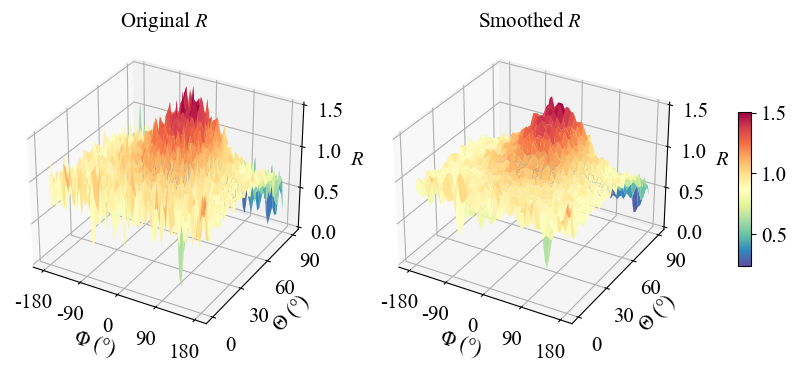

In [272]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D

# --- Font setup ---
font = 15
fontfml = 'Times New Roman'
plt.rcParams['font.size'] = font
plt.rcParams['font.family'] = fontfml
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = fontfml
plt.rcParams['mathtext.it'] = f'{fontfml}:italic'
plt.rcParams['mathtext.bf'] = f'{fontfml}:bold'

# --- Dummy data (replace with actual data) ---
# H_c = np.random.rand(45, 72)
# result = np.random.rand(45, 72)

# --- Metrics ---
mae = np.mean(np.abs(result - H_c))
rmse = np.sqrt(np.mean((result - H_c) ** 2))
corr = np.corrcoef(result.flatten(), H_c.flatten())[0, 1]

# --- Coordinates ---
n_theta, n_phi = H_c.shape
theta = np.linspace(0, 90, n_theta)
phi = np.linspace(-180, 180, n_phi)
PHI, THETA = np.meshgrid(phi, theta)

# --- Create figure and GridSpec ---
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 2)  # Make subplot 3 thinner
gs.update(wspace=-0.3)  # Tight spacing between 1 and 2, bigger gap before 3

# --- Subplot 1: Original H_c ---
ax0 = fig.add_subplot(gs[0], projection='3d')
surf0 = ax0.plot_surface(PHI, THETA, H_c, cmap='Spectral_r', edgecolor='none', antialiased=True)
ax0.set_title('Original $R$', fontsize=font)
ax0.set_xlabel(r'$\Phi$ (°)', fontsize=font)
ax0.set_ylabel(r'$\Theta$ (°)', fontsize=font)
ax0.set_zlabel(r'$R$', fontsize=font)
ax0.view_init(elev=30, azim=-60)
ax0.set_zlim(0, 1.5)
ax0.set_xticks(np.arange(-180, 181, 90))
ax0.set_xticklabels([f'{d}' for d in np.arange(-180, 181, 90)])
ax0.set_yticks(np.arange(0, 91, 30))
ax0.set_yticklabels([f'{d}' for d in np.arange(0, 91, 30)])
#fig.colorbar(surf0, ax=ax0, shrink=0.5, aspect=20, pad=0.1)

# --- Subplot 2: Smoothed result ---
ax1 = fig.add_subplot(gs[1], projection='3d')
surf1 = ax1.plot_surface(PHI, THETA, result, cmap='Spectral_r', edgecolor='none', antialiased=True)
ax1.set_title('Smoothed $R$', fontsize=font)
ax1.set_xlabel(r'$\Phi$ (°)', fontsize=font)
ax1.set_ylabel(r'$\Theta$ (°)', fontsize=font)
ax1.set_zlabel(r'$R$', fontsize=font)
ax1.view_init(elev=30, azim=-60)
ax1.set_zlim(0, 1.5)
ax1.set_xticks(np.arange(-180, 181, 90))
ax1.set_xticklabels([f'{d}' for d in np.arange(-180, 181, 90)])
ax1.set_yticks(np.arange(0, 91, 30))
ax1.set_yticklabels([f'{d}' for d in np.arange(0, 91, 30)])
fig.colorbar(surf0, ax=ax1, shrink=0.5, aspect=12, pad=0.1)


# --- Title and layout ---
#plt.suptitle("Comparison of Original and Smoothed Angular Distribution $R$", fontsize=font + 1, y=1.05)
plt.tight_layout()
fig_dir = 'figures/'
fig.savefig(fig_dir+'Smooth_R_3D.png', dpi=300, bbox_inches='tight')

plt.show()

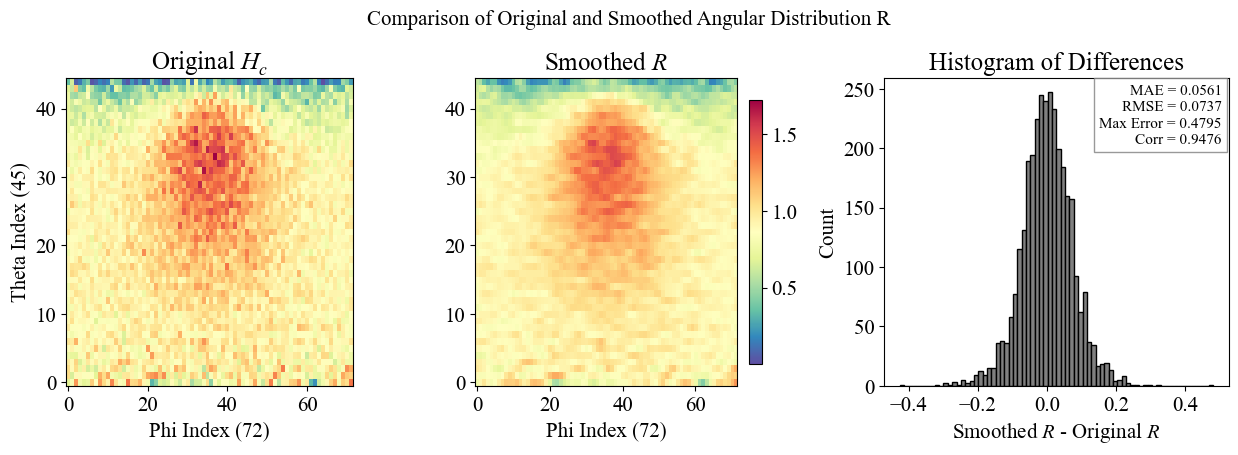

In [277]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# --- Your metrics calculations ---
mae = np.mean(np.abs(result - H_c))
rmse = np.sqrt(np.mean((result - H_c)**2))
max_err = np.max(np.abs(result - H_c))
corr = np.corrcoef(result.flatten(), H_c.flatten())[0, 1]

# --- Shared color limits for imshow ---
vmin = min(H_c.min(), result.min())
vmax = max(H_c.max(), result.max())

# --- Create figure with 3 subplots using GridSpec ---
fig = plt.figure(figsize=(15, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1.2])
gs.update(wspace=0.4, hspace=0.15)

# --- Plot 1: Original H_c ---
ax0 = fig.add_subplot(gs[0])
im0 = ax0.imshow(H_c, cmap='Spectral_r', aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
ax0.set_title('Original $H_c$')
ax0.set_xlabel('Phi Index (72)')
ax0.set_ylabel('Theta Index (45)')
#plt.colorbar(im0, ax=ax0, fraction=0.046, pad=0.04)

# --- Plot 2: Smoothed result ---
ax1 = fig.add_subplot(gs[1])
im1 = ax1.imshow(result, cmap='Spectral_r', aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
ax1.set_title('Smoothed $R$')
ax1.set_xlabel('Phi Index (72)')
ax1.set_ylabel('')
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

# --- Plot 3: Histogram of Differences ---
ax2 = fig.add_subplot(gs[2])
diff = (result - H_c).flatten()
ax2.hist(diff, bins=72, color='gray', edgecolor='black')
ax2.set_title("Histogram of Differences")
ax2.set_xlabel("Smoothed $R$ - Original $R$")
ax2.set_ylabel("Count")

# --- Add metrics as text box on the histogram ---
metrics_text = (
    f"MAE = {mae:.4f}\n"
    f"RMSE = {rmse:.4f}\n"
    f"Max Error = {max_err:.4f}\n"
    f"Corr = {corr:.4f}"
)
# Place text in the upper right of the histogram axes
ax2.text(0.98, 0.98, metrics_text, transform=ax2.transAxes,
         fontsize=11, va='top', ha='right',
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

fig_dir = 'figures/'
fig.savefig(fig_dir+'Smooth_R_2D.png', dpi=300, bbox_inches='tight')
plt.suptitle("Comparison of Original and Smoothed Angular Distribution R", fontsize=15, y=1.05)
plt.tight_layout()
plt.show()


In [280]:
check_normalization(H_c)/np.pi

1.0000000000000002

In [281]:
check_normalization(result)/np.pi

0.9990058071950786

### smooth 

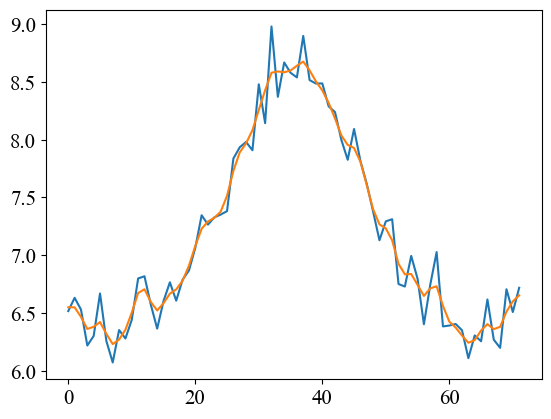

In [136]:
# Smooth along axis 1 (phi), keep theta rows unchanged
plt.plot(np.sum(H_theta_intg,axis=0))
H_theta_smooth = gaussian_filter1d(H_theta_intg, sigma=1, axis=1,mode='reflect')
plt.plot(np.sum(H_theta_smooth,axis=0))

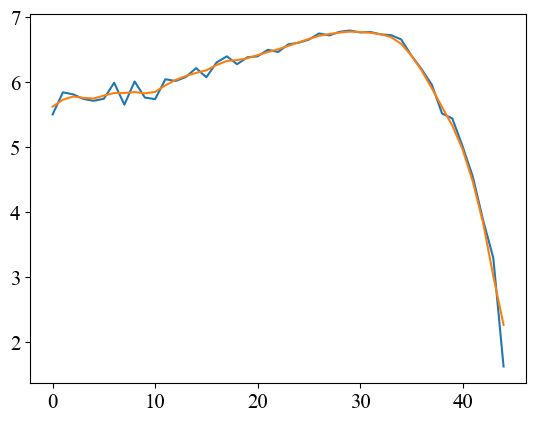

In [100]:
plt.plot(H_phi_intg)
from scipy.ndimage import gaussian_filter1d

# H_phi_intg is a 1D NumPy array
H_phi_smooth = gaussian_filter1d(H_phi_intg, sigma=1)
plt.plot(H_phi_smooth)

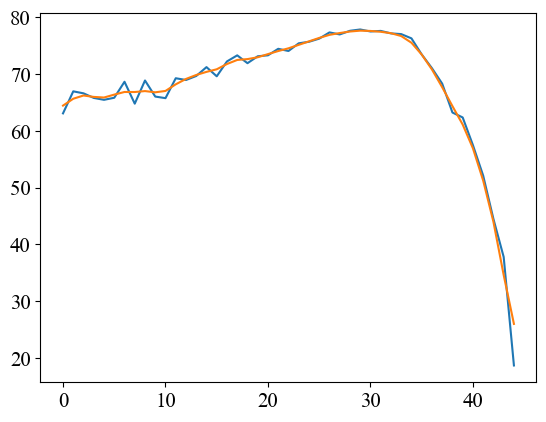

In [138]:
plt.plot(np.sum(H_c,axis=1))
plt.plot(np.sum(result,axis=1))